# Proyecto Dataset Diabético

## 📊 Resumen del Dataset

- **Dimensiones**: 101,766 registros × 50 columnas
- **Variable objetivo**: `readmitted` (NO, <30 días, >30 días)
- **Tipo de problema**: Clasificación multiclase (puede convertirse a binaria)

---


In [1]:
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

<div align="center">

# LINDA

</div>

### Introducción y carga de datos
_Aquí daremos una breve descripción del problema, marcaremos ,los objetivos del proyecto y se hará la carga del dataset y la inspección inicial._

In [2]:
df = pd.read_csv("data/diabetic_data.csv")
    
print(f"\n✓ Dataset cargado exitosamente")
print(f"  Dimensiones originales: {df.shape[0]} filas × {df.shape[1]} columnas")


✓ Dataset cargado exitosamente
  Dimensiones originales: 101766 filas × 50 columnas


### Inspección Inicial del Dataset

In [3]:
# Información general del dataset
print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 80)
df.info()

INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            1

In [4]:
# Primeras filas del dataset
print("\n" + "=" * 80)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 80)
display(df.head())


PRIMERAS 5 FILAS DEL DATASET


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# Estadísticas descriptivas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
display(df.describe())


ESTADÍSTICAS DESCRIPTIVAS


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


## Limpieza y Preprocesamiento de Datos

### Análisis de valores faltantes

In [6]:
# Análisis de valores faltantes
print("\n" + "=" * 80)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 80)

# Valores '?' que se consideran como faltantes
missing_counts = (df == '?').sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_counts) > 0:
    print("\nColumnas con '?' (valores faltantes):")
    for col, count in missing_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {col:30s}: {count:6d} ({pct:5.2f}%)")
else:
    print("No hay valores '?' en el dataset")

# Valores NaN tradicionales
nan_counts = df.isnull().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)

if len(nan_counts) > 0:
    print("\nColumnas con NaN:")
    for col, count in nan_counts.items():
        pct = (count / len(df)) * 100
        print(f"  {col:30s}: {count:6d} ({pct:5.2f}%)")
else:
    print("\nNo hay valores NaN en el dataset")


ANÁLISIS DE VALORES FALTANTES

Columnas con '?' (valores faltantes):
Columnas con '?' (valores faltantes):
  weight                        :  98569 (96.86%)
  medical_specialty             :  49949 (49.08%)
  payer_code                    :  40256 (39.56%)
  race                          :   2273 ( 2.23%)
  diag_3                        :   1423 ( 1.40%)
  diag_2                        :    358 ( 0.35%)
  diag_1                        :     21 ( 0.02%)

Columnas con NaN:
  max_glu_serum                 :  96420 (94.75%)
  A1Cresult                     :  84748 (83.28%)

  weight                        :  98569 (96.86%)
  medical_specialty             :  49949 (49.08%)
  payer_code                    :  40256 (39.56%)
  race                          :   2273 ( 2.23%)
  diag_3                        :   1423 ( 1.40%)
  diag_2                        :    358 ( 0.35%)
  diag_1                        :     21 ( 0.02%)

Columnas con NaN:
  max_glu_serum                 :  96420 (94.75%)
  A

### Análisis de duplicados

In [7]:
# Análisis de duplicados
print("\n" + "=" * 80)
print("ANÁLISIS DE DUPLICADOS")
print("=" * 80)

# Duplicados por encounter_id (cada encuentro debe ser único)
duplicate_encounters = df['encounter_id'].duplicated().sum()
print(f"Registros duplicados por encounter_id: {duplicate_encounters}")

# Duplicados por patient_nbr (un paciente puede tener múltiples encuentros)
unique_patients = df['patient_nbr'].nunique()
total_encounters = len(df)
print(f"Pacientes únicos: {unique_patients}")
print(f"Total de encuentros: {total_encounters}")
print(f"Promedio de encuentros por paciente: {total_encounters / unique_patients:.2f}")


ANÁLISIS DE DUPLICADOS
Registros duplicados por encounter_id: 0
Pacientes únicos: 71518
Total de encuentros: 101766
Promedio de encuentros por paciente: 1.42


### Eliminación de columnas irrelevantes

**Eliminación de columnas con mayoría de nulos**

Dado que la columna ``weight`` tiene un 97% de nulos, consideramos que la mejor estrategia es eliminarla. Asímismo, con un p-value de ``0.83``, las diferencias en tasas de readmisión entre las categorías de HbA1c (``A1CResult``) NO son estadísticamente significativas.
Esto significa que la tasa de readmisión NO varía significativamente según el control glucémico medido por HbA1c
HbA1c NO tiene poder predictivo para readmisión <30 días en este dataset. Cualquier diferencia observada es atribuible al azar. Por eso la decisión de eliminarla directamente.

In [8]:
# Drop columna 'weight'
print("\n" + "=" * 80)
print("ANÁLISIS Y ELIMINACIÓN DE 'WEIGHT'")
print("=" * 80)
df = df.drop(columns=['weight', 'A1Cresult'])
print(f"  Dimensiones después de eliminar 'weight' y 'A1Cresult': {df.shape[0]} filas × {df.shape[1]} columnas")


ANÁLISIS Y ELIMINACIÓN DE 'WEIGHT'
  Dimensiones después de eliminar 'weight' y 'A1Cresult': 101766 filas × 48 columnas


**Eliminación de IDs no informativos: ``encounter_id`` y ``patient_nbr``** <br><br>
Eliminamos ``encounter_id`` y ``patient_nbr`` porque son IDENTIFICADORES no informativos:

1.  **encounter_id (ID de encuentro hospitalario)**: Es un identificador ÚNICO para cada registro (101,766 valores únicos) que no tiene valor predictivo: es simplemente un número de referencia administrativo.


2.  **patient_nbr (ID de paciente)**: Aunque un paciente puede tener múltiples ingresos (promedio: 1.42 encuentros), el ID del paciente en sí mismo NO es predictivo. Mantener 'patient_nbr' introduciría sesgo hacia pacientes específicos en lugar de características clínicas generalizables.

In [9]:
print("\n" + "=" * 80)
print("ELIMINACIÓN DE IDs NO INFORMATIVOS: encounter_id y patient_nbr")
print("=" * 80)

# Verificar unicidad de encounter_id
print(f"\nencounter_id:")
print(f"  Valores únicos: {df['encounter_id'].nunique():,}")
print(f"  Total de filas: {len(df):,}")
print(f"  ¿Todos únicos?: {df['encounter_id'].nunique() == len(df)}")

# Analizar patient_nbr
print(f"\npatient_nbr:")
print(f"  Pacientes únicos: {df['patient_nbr'].nunique():,}")
print(f"  Total de encuentros: {len(df):,}")
print(f"  Promedio de encuentros por paciente: {len(df) / df['patient_nbr'].nunique():.2f}")

# Proceder con la eliminación
print("\n" + "=" * 80)
print("ELIMINANDO COLUMNAS ID...")
print("=" * 80)

df = df.drop(columns=['encounter_id', 'patient_nbr'])

print(f"✓ Columnas 'encounter_id' y 'patient_nbr' eliminadas exitosamente")
print(f"✓ Dimensiones actuales del dataset: {df.shape[0]:,} filas × {df.shape[1]} columnas")


ELIMINACIÓN DE IDs NO INFORMATIVOS: encounter_id y patient_nbr

encounter_id:
  Valores únicos: 101,766
  Total de filas: 101,766
  ¿Todos únicos?: True

patient_nbr:
  Pacientes únicos: 71,518
  Total de encuentros: 101,766
  Promedio de encuentros por paciente: 1.42

ELIMINANDO COLUMNAS ID...
✓ Columnas 'encounter_id' y 'patient_nbr' eliminadas exitosamente
✓ Dimensiones actuales del dataset: 101,766 filas × 46 columnas


### Imputación de valores faltantes

**Imputación de ``race`` con la moda** <br><br>
La variable ``race`` presenta solo un 2.23% de valores faltantes, una proporción relativamente baja que no compromete significativamente el dataset.

Decidimos imputar con la MODA por las siguientes razones:

1. **Preservación de datos**: Eliminar estos registros reduciría innecesariamente
   el tamaño del dataset (~2,300 registros).

2. **Mínimo sesgo introducido**: Con solo 2.23% de valores faltantes, la imputación
   con moda introduce un sesgo mínimo en la distribución de la variable.

3. **Alternativas descartadas**:
   - Crear categoría "Unknown": No aporta información y puede confundir a los modelos
   - Imputación predictiva: Complejidad injustificada para un 2.23% de faltantes

La imputación con moda es una estrategia conservadora y apropiada para variables
categóricas con baja proporción de valores faltantes.

**Imputación de ``race`` con la moda**

In [10]:
print("\n" + "=" * 80)
print("IMPUTACIÓN DE 'RACE' CON LA MODA")
print("=" * 80)
# Paso 1: Convertir '?' a NaN solo en la columna 'race'
df['race'] = df['race'].replace('?', np.nan)

# Paso 2: Backup y verificación
print("Valores nulos originales en 'race':", df['race'].isna().sum())
df['race_backup'] = df['race'].copy()

# Paso 3: Imputación
race_imputer = SimpleImputer(strategy='most_frequent')
df['race'] = race_imputer.fit_transform(df[['race']]).ravel()

# Paso 4: Identificar valores imputados
imputed_mask = df['race_backup'].isna() & df['race'].notna()
imputed_values = df.loc[imputed_mask, 'race']

print(f"\nSe imputaron {len(imputed_values)} valores:")
print(imputed_values.value_counts())



IMPUTACIÓN DE 'RACE' CON LA MODA
Valores nulos originales en 'race': 2273

Se imputaron 2273 valores:
race
Caucasian    2273
Name: count, dtype: int64


### Sustitución de Valores Faltantes en `payer_code` y `medical_specialty`

Optamos por crear una categoría explícita `"Unknown"` en lugar de eliminar registros o imputar con la moda, ya que la ausencia de información en estas columnas puede ser informativa por sí misma.

La falta de información del pagador (`payer_code`) puede reflejar situaciones como pacientes sin seguro médico o casos de emergencia donde la documentación no fue completada adecuadamente. De manera similar, la ausencia de especialidad médica asignada (`medical_specialty`) puede indicar atención generalista o admisiones de emergencia sin derivación específica.

Ambas columnas presentan una proporción considerable de valores faltantes. Eliminar estos registros comprometería significativamente la capacidad de análisis, mientras que la imputación con moda introduciría sesgo al asumir que todos los valores faltantes pertenecen a la categoría más frecuente.

Al preservar estos registros mediante la categoría `"Unknown"`, mantenemos la integridad del dataset y permitimos que los modelos de machine learning evalúen si la ausencia de esta información administrativa es predictiva de readmisión hospitalaria.

In [11]:
print("=" * 80)
print("ANÁLISIS DE VALORES FALTANTES: payer_code y medical_specialty")
print("=" * 80)

# Calcular porcentajes de valores '?' (que serán reemplazados por 'Unknown')
total_rows = len(df)

payer_missing = (df['payer_code'] == '?').sum()
payer_pct = (payer_missing / total_rows) * 100

specialty_missing = (df['medical_specialty'] == '?').sum()
specialty_pct = (specialty_missing / total_rows) * 100

print(f"\npayer_code:")
print(f"  Valores '?': {payer_missing:,} ({payer_pct:.2f}%)")

print(f"\nmedical_specialty:")
print(f"  Valores '?': {specialty_missing:,} ({specialty_pct:.2f}%)")

print(f"\n✓ Estos valores serán reemplazados por 'Unknown'")

ANÁLISIS DE VALORES FALTANTES: payer_code y medical_specialty

payer_code:
  Valores '?': 40,256 (39.56%)

medical_specialty:
  Valores '?': 49,949 (49.08%)

✓ Estos valores serán reemplazados por 'Unknown'


In [12]:
# Sustituir '?' por 'Unknown' en payer_code y medical_specialty
df['payer_code'] = df['payer_code'].replace('?', 'Unknown')
df['medical_specialty'] = df['medical_specialty'].replace('?', 'Unknown')

print(f"✓ Valores '?' reemplazados por 'Unknown' en payer_code y medical_specialty")
print(f"  payer_code: {(df['payer_code'] == 'Unknown').sum()} valores 'Unknown'")
print(f"  medical_specialty: {(df['medical_specialty'] == 'Unknown').sum()} valores 'Unknown'")

✓ Valores '?' reemplazados por 'Unknown' en payer_code y medical_specialty
  payer_code: 40256 valores 'Unknown'
  medical_specialty: 49949 valores 'Unknown'

  payer_code: 40256 valores 'Unknown'
  medical_specialty: 49949 valores 'Unknown'


### Transformación de Variable Objetivo
El dataset original contiene la variable `readmitted` con tres categorías:
- `NO`: El paciente no fue readmitido
- `>30`: El paciente fue readmitido después de 30 días
- `<30`: El paciente fue readmitido en menos de 30 días

Nuestro objetivo es **predecir readmisiones tempranas** (en menos de 30 días), ya que estas representan:

1. **Mayor costo para el sistema de salud:** Las readmisiones tempranas suelen estar relacionadas con complicaciones evitables o alta prematura. En EEUU, donde se recopiló la información, Medicare suele penalizar a los hospitales cuyos pacientes son ingresados de nuevo en un período de 30 días o menos.

2. **Indicador de calidad asistencial:** Una readmisión en <30 días puede señalar deficiencias en el plan de alta, seguimiento inadecuado o falta de educación al paciente.

3. **Oportunidad de intervención:** Identificar pacientes en riesgo de readmisión temprana permite implementar programas de seguimiento intensivo post-alta.
<br><br>


**Decisión de Modelado** <br>
Transformaremos el problema en **clasificación binaria**:
- **Clase positiva (1):** Readmisión en <30 días
- **Clase negativa (0):** No readmisión o readmisión >30 días

Esta decisión implica que tratamos las readmisiones tardías (>30 días) como "no problemáticas" desde la perspectiva de calidad asistencial inmediata, enfocándonos en prevenir las readmisiones que ocurren poco después del alta hospitalaria.

TRANSFORMACIÓN DE VARIABLE OBJETIVO

✓ Columna 'readmitted' encontrada

Distribución original:
   NO: 54,864 (53.91%)
  >30: 35,545 (34.93%)
  <30: 11,357 (11.16%)

CREANDO VARIABLE BINARIA

✓ Transformación aplicada:
   Lógica: '<30' → 1 (Readmitido <30 días)
          'NO' + '>30' → 0 (No readmitido <30 días)

VERIFICACIÓN CRUZADA

Tabla de contingencia (readmitted vs readmitted_binary):
readmitted_binary      0      1     All
readmitted                             
<30                    0  11357   11357
>30                35545      0   35545
NO                 54864      0   54864
All                90409  11357  101766

DISTRIBUCIÓN FINAL DE VARIABLE OBJETIVO

Distribución de 'readmitted_binary':
  0 (Sin readmisión <30 días): 90,409 (88.84%)
  1 (Readmitido <30 días):      11,357 (11.16%)

  Ratio de desbalanceo: 7.96:1
    → Dataset DESBALANCEADO. Se recomienda:
       • SMOTE para oversampling de la clase minoritaria
       • class_weight='balanced' en los modelos
       • Pri

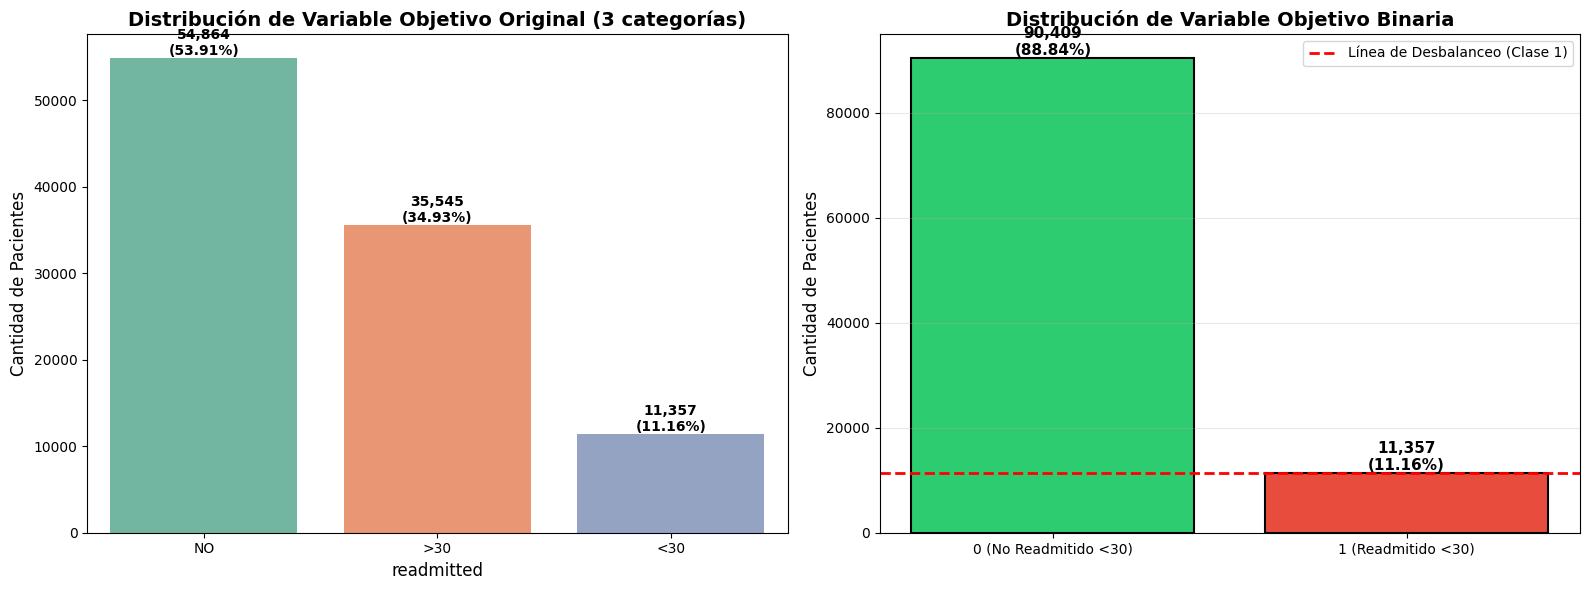


✅ TRANSFORMACIÓN COMPLETADA EXITOSAMENTE


In [13]:
print("=" * 80)
print("TRANSFORMACIÓN DE VARIABLE OBJETIVO")
print("=" * 80)

# PASO 1: Verificar si existe la columna original 'readmitted'
# PASO 1: Verificar existencia y guardar copia de la columna 'readmitted'
if 'readmitted' not in df.columns:
    raise ValueError("Columna 'readmitted' no encontrada. Carga el dataset original (diabetic_data.csv)")

print("\n✓ Columna 'readmitted' encontrada")
print("\nDistribución original:")
for cat, cnt in df['readmitted'].value_counts().items():
    print(f"  {cat:>3}: {cnt:>6,} ({cnt/len(df)*100:>5.2f}%)")

original_readmitted = df['readmitted'].copy()

# PASO 2: Crear/Sobrescribir readmitted_binary CORRECTAMENTE
print("\n" + "=" * 80)
print("CREANDO VARIABLE BINARIA")
print("=" * 80)

# Transformación CORRECTA: '<30' → 1, resto (NO + >30) → 0
df['readmitted_binary'] = (df['readmitted'] == '<30').astype(int)

print("\n✓ Transformación aplicada:")
print("   Lógica: '<30' → 1 (Readmitido <30 días)")
print("          'NO' + '>30' → 0 (No readmitido <30 días)")

# PASO 3: Verificación cruzada
print("\n" + "=" * 80)
print("VERIFICACIÓN CRUZADA")
print("=" * 80)

cross_check = pd.crosstab(df['readmitted'], df['readmitted_binary'], margins=True)
print("\nTabla de contingencia (readmitted vs readmitted_binary):")
print(cross_check)

# PASO 4: Distribución final
print("\n" + "=" * 80)
print("DISTRIBUCIÓN FINAL DE VARIABLE OBJETIVO")
print("=" * 80)

readmit_counts = df['readmitted_binary'].value_counts().sort_index()
cnt0 = int(readmit_counts.get(0, 0))
cnt1 = int(readmit_counts.get(1, 0))

print("\nDistribución de 'readmitted_binary':")
print(f"  0 (Sin readmisión <30 días): {cnt0:,} ({(cnt0/len(df)*100):.2f}%)")
print(f"  1 (Readmitido <30 días):      {cnt1:,} ({(cnt1/len(df)*100):.2f}%)")

# Calcular desbalanceo
if cnt1 > 0:
    imbalance_ratio = cnt0 / cnt1
    print(f"\n  Ratio de desbalanceo: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 3:
        print(f"    → Dataset DESBALANCEADO. Se recomienda:")
        print(f"       • SMOTE para oversampling de la clase minoritaria")
        print(f"       • class_weight='balanced' en los modelos")
        print(f"       • Priorizar métricas: Recall, F1-Score, AUC-ROC")
    else:
        print(f"    → Desbalanceo moderado. Monitorear F1-Score y AUC-ROC")
else:
    print("\n  ⚠️  ERROR: No hay casos positivos (clase 1)")
    raise ValueError("La transformación falló: no hay casos de readmisión <30 días")

# PASO 5: Validación final
print("\n" + "=" * 80)
print("VALIDACIÓN FINAL")
print("=" * 80)

# Valores esperados según el dataset original
expected_0 = (df['readmitted'].isin(['NO', '>30'])).sum()
expected_1 = (df['readmitted'] == '<30').sum()

print(f"\nValores esperados:")
print(f"  Clase 0: {expected_0:,}")
print(f"  Clase 1: {expected_1:,}")

print(f"\nValores obtenidos:")
print(f"  Clase 0: {cnt0:,}")
print(f"  Clase 1: {cnt1:,}")

# Verificar coincidencia
if cnt0 == expected_0 and cnt1 == expected_1:
    print("\n✅ VALIDACIÓN EXITOSA: La transformación es CORRECTA")
else:
    print("\n❌ ERROR EN LA VALIDACIÓN")
    print(f"   Diferencia clase 0: {cnt0 - expected_0}")
    print(f"   Diferencia clase 1: {cnt1 - expected_1}")
    raise ValueError("La transformación no coincide con los valores esperados")

# PASO 6: Eliminar columna original para evitar data leakage
df = df.drop(columns=['readmitted'], errors='ignore')
print(f"\n✓ Columna 'readmitted' eliminada para evitar data leakage")
print(f"✓ Variable objetivo final: 'readmitted_binary'")

# PASO 7: Visualizaciones
print("\n" + "=" * 80)
print("GENERANDO VISUALIZACIONES")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Distribución original (3 categorías)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
sns.countplot(x=original_readmitted, order=original_readmitted.value_counts().index, ax=ax, palette='Set2')
ax.set_title('Distribución de Variable Objetivo Original (3 categorías)', fontsize=14, fontweight='bold')
ax.set_xlabel('readmitted', fontsize=12)
ax.set_ylabel('Cantidad de Pacientes', fontsize=12)

total_orig = len(original_readmitted)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}\n({(height/total_orig)*100:.2f}%)',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 2: Distribución binaria (2 categorías)
ax = axes[1]
colors = ['#2ecc71', '#e74c3c']
labels = ['0 (No Readmitido <30)', '1 (Readmitido <30)']

bars = ax.bar(labels, readmit_counts.values, color=colors, edgecolor='black', linewidth=1.5)

for bar, count in zip(bars, readmit_counts.values):
    height = bar.get_height()
    pct = (count / len(df)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({pct:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Distribución de Variable Objetivo Binaria', fontsize=14, fontweight='bold')
ax.set_ylabel('Cantidad de Pacientes', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Línea de desbalanceo
if cnt1 > 0:
    ax.axhline(y=cnt1, color='red', linestyle='--', linewidth=2, label=f'Línea de Desbalanceo (Clase 1)')
    ax.legend()

plt.tight_layout()
plt.show()


print("\n" + "=" * 80)
print("✅ TRANSFORMACIÓN COMPLETADA EXITOSAMENTE")
print("=" * 80)

## Encoding de Variables Categóricas

In [14]:
# Identificar columnas categóricas y numéricas
print("=" * 80)
print("PREPARACIÓN PARA ENCODING")
print("=" * 80)

# Columnas a excluir del encoding (IDs y columnas ya procesadas)
exclude_cols = ['encounter_id', 'patient_nbr', 'readmitted', 'readmitted_binary', 'early_readmission']

# Identificar columnas categóricas (object type)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print(f"\nColumnas categóricas identificadas ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"  {col:30s}: {unique_count:3d} valores únicos")

# Separar entre nominales (muchos valores) y binarias/ordinales
high_cardinality_cols = [col for col in categorical_cols if df[col].nunique() > 10]
low_cardinality_cols = [col for col in categorical_cols if df[col].nunique() <= 10]

print(f"\nColumnas de alta cardinalidad (>10 valores): {len(high_cardinality_cols)}")
print(f"Columnas de baja cardinalidad (≤10 valores): {len(low_cardinality_cols)}")

PREPARACIÓN PARA ENCODING

Columnas categóricas identificadas (35):
  race                          :   5 valores únicos
  gender                        :   3 valores únicos
  age                           :  10 valores únicos
  payer_code                    :  18 valores únicos
  medical_specialty             :  73 valores únicos
  diag_1                        : 717 valores únicos
  diag_2                        : 749 valores únicos
  diag_3                        : 790 valores únicos
  max_glu_serum                 :   3 valores únicos
  metformin                     :   4 valores únicos
  repaglinide                   :   4 valores únicos
  nateglinide                   :   4 valores únicos
  chlorpropamide                :   4 valores únicos
  glimepiride                   :   4 valores únicos
  acetohexamide                 :   2 valores únicos
  glipizide                     :   4 valores únicos
  glyburide                     :   4 valores únicos
  tolbutamide                  

In [15]:
# Aplicar Label Encoding a columnas de baja cardinalidad
from sklearn.preprocessing import LabelEncoder

print("\n" + "=" * 80)
print("LABEL ENCODING (para columnas de baja cardinalidad)")
print("=" * 80)

label_encoders = {}
df_encoded = df.copy()

for col in low_cardinality_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"✓ {col}: {len(le.classes_)} clases codificadas")

print(f"\n✓ Total de columnas con Label Encoding: {len(low_cardinality_cols)}")


LABEL ENCODING (para columnas de baja cardinalidad)
✓ race: 5 clases codificadas
✓ gender: 3 clases codificadas
✓ age: 10 clases codificadas
✓ max_glu_serum: 4 clases codificadas
✓ metformin: 4 clases codificadas
✓ repaglinide: 4 clases codificadas
✓ nateglinide: 4 clases codificadas
✓ chlorpropamide: 4 clases codificadas
✓ glimepiride: 4 clases codificadas
✓ acetohexamide: 2 clases codificadas
✓ glipizide: 4 clases codificadas
✓ glyburide: 4 clases codificadas
✓ tolbutamide: 2 clases codificadas
✓ pioglitazone: 4 clases codificadas
✓ rosiglitazone: 4 clases codificadas
✓ acarbose: 4 clases codificadas
✓ pioglitazone: 4 clases codificadas
✓ rosiglitazone: 4 clases codificadas
✓ acarbose: 4 clases codificadas
✓ miglitol: 4 clases codificadas
✓ troglitazone: 2 clases codificadas
✓ tolazamide: 3 clases codificadas
✓ examide: 1 clases codificadas
✓ citoglipton: 1 clases codificadas
✓ insulin: 4 clases codificadas
✓ glyburide-metformin: 4 clases codificadas
✓ glipizide-metformin: 2 clases 

In [16]:
# Aplicar One-Hot Encoding a columnas de alta cardinalidad
print("\n" + "=" * 80)
print("ONE-HOT ENCODING (para columnas de alta cardinalidad)")
print("=" * 80)

# Para evitar explosión dimensional, limitaremos las columnas de alta cardinalidad
# o usaremos frequency encoding como alternativa

print(f"\nColumnas de alta cardinalidad que se procesarán:")
for col in high_cardinality_cols:
    print(f"  {col}: {df_encoded[col].nunique()} valores únicos")

# Decisión: Para payer_code (18 valores) aplicaremos One-Hot
# Para las demás columnas con demasiados valores (diagnosis codes),
# usaremos Label Encoding ya que One-Hot crearía demasiadas columnas

# Columnas para One-Hot (cardinalidad moderada)
onehot_cols = ['payer_code']  # 18 valores únicos es manejable
onehot_cols = [col for col in onehot_cols if col in high_cardinality_cols]

if onehot_cols:
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, prefix=onehot_cols, drop_first=True)
    print(f"\n✓ One-Hot Encoding aplicado a: {onehot_cols}")
    print(f"  Nuevas columnas creadas: {len([c for c in df_encoded.columns if any(pc in c for pc in onehot_cols)])}")
else:
    print("\n⚠️  No hay columnas seleccionadas para One-Hot Encoding")

# Para las demás columnas de alta cardinalidad, aplicar Label Encoding
remaining_high_card = [col for col in high_cardinality_cols if col not in onehot_cols]
for col in remaining_high_card:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"✓ Label Encoding aplicado a {col}")

print(f"\n✓ Encoding completo. Nueva dimensión: {df_encoded.shape}")


ONE-HOT ENCODING (para columnas de alta cardinalidad)

Columnas de alta cardinalidad que se procesarán:
  payer_code: 18 valores únicos
  medical_specialty: 73 valores únicos
  diag_1: 717 valores únicos
  diag_2: 749 valores únicos
  diag_3: 790 valores únicos

✓ One-Hot Encoding aplicado a: ['payer_code']
  Nuevas columnas creadas: 17
✓ Label Encoding aplicado a medical_specialty
✓ Label Encoding aplicado a diag_1
✓ Label Encoding aplicado a diag_2
✓ Label Encoding aplicado a diag_3

✓ Encoding completo. Nueva dimensión: (101766, 63)

✓ One-Hot Encoding aplicado a: ['payer_code']
  Nuevas columnas creadas: 17
✓ Label Encoding aplicado a medical_specialty
✓ Label Encoding aplicado a diag_1
✓ Label Encoding aplicado a diag_2
✓ Label Encoding aplicado a diag_3

✓ Encoding completo. Nueva dimensión: (101766, 63)


## Feature Engineering
En esta sección creamos tres features clave:

**1. `total_visits`**: Historial total de visitas hospitalarias. <br>
Suma de visitas ambulatorias (`number_outpatient`), emergencias (`number_emergency`) e ingresos previos (`number_inpatient`).

Los pacientes con historial extenso de hospitalizaciones pueden tener condiciones crónicas más complejas o menor adherencia al tratamiento, incrementando el riesgo de readmisión temprana.

---

**2. `medication_changes`**: Indicador de cambios en tratamiento
Suma de `change` (cambio en medicación durante hospitalización) y `diabetesMed` (prescripción de medicamentos para diabetes).

Los ajustes de medicación reflejan inestabilidad clínica o complejidad en el manejo de la diabetes. Pacientes que requieren cambios frecuentes pueden tener mayor dificultad para mantener control glucémico post-alta.

---

**3. `procedures_per_day`**: Intensidad de la atención hospitalaria
Ratio entre el número de procedimientos realizados (`num_procedures`) y los días de hospitalización (`time_in_hospital`).

Una alta densidad de procedimientos puede indicar casos más críticos o complicaciones durante la estancia, factores asociados con mayor probabilidad de readmisión.

---

Estas variables condensan información clínica relevante que puede no ser evidente en las variables individuales, facilitando que los modelos identifiquen patrones de riesgo.

In [17]:
## Feature Engineering
print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Feature 1: Total de visitas (outpatient + emergency + inpatient)
df_encoded['total_visits'] = (df_encoded['number_outpatient'] + 
                               df_encoded['number_emergency'] + 
                               df_encoded['number_inpatient'])
print(f"✓ Feature creada: total_visits")
print(f"  Rango: [{df_encoded['total_visits'].min()}, {df_encoded['total_visits'].max()}]")
print(f"  Media: {df_encoded['total_visits'].mean():.2f}")

# Feature 2: Cambios en medicación (change + diabetesMed)
# Nota: 'change' y 'diabetesMed' ya fueron codificadas con LabelEncoder
# en la sección anterior, por lo que ya son variables numéricas
df_encoded['medication_changes'] = df_encoded['change'] + df_encoded['diabetesMed']
print(f"\n✓ Feature creada: medication_changes")
print(f"  Rango: [{df_encoded['medication_changes'].min()}, {df_encoded['medication_changes'].max()}]")
print(f"  Distribución:")
print(df_encoded['medication_changes'].value_counts().sort_index())

# Feature 3: Ratio de procedimientos por día hospitalizado
df_encoded['procedures_per_day'] = df_encoded['num_procedures'] / (df_encoded['time_in_hospital'] + 1)  # +1 para evitar división por 0
print(f"\n✓ Feature creada: procedures_per_day")
print(f"  Media: {df_encoded['procedures_per_day'].mean():.2f}")

print(f"\n✓ Feature Engineering completado. Total de features: {df_encoded.shape[1]}")

FEATURE ENGINEERING
✓ Feature creada: total_visits
  Rango: [0, 80]
  Media: 1.20

✓ Feature creada: medication_changes
  Rango: [1, 2]
  Distribución:
medication_changes
1    70414
2    31352
Name: count, dtype: int64

✓ Feature creada: procedures_per_day
  Media: 0.30

✓ Feature Engineering completado. Total de features: 66


### Categorización ICD-9
El ICD-9 (_International Classification of Diseases, 9ª revisión_) es un sistema estandarizado utilizado para **clasificar y codificar enfermedades, síntomas, causas externas y ciertos procedimientos médicos**. Cada diagnóstico se representa mediante un código numérico de 3 a 5 dígitos:
- **Primeros 3 dígitos**: definen la categoría general (tipo de enfermedad o condición).
- **Dígitos adicionales**: aportan mayor especificidad, indicando detalles como localización, tipo, gravedad u otras características.

La estructura del ICD-9 se organiza en **capítulos temáticos**, agrupando las patologías según el sistema afectado (por ejemplo: _enfermedades infecciosas, sistema respiratorio, sistema cardiovascular_, entre otros).

En esta sección nuestro objetivo es transformar **códigos específicos** (250.01 o 428.0, por ejemplo) en **etiquetas interpretables** como _Diabetes, Circulatory, Respiratory_, entre otros. Esto facilita el modelado y análisis estadístico, ya que:

- Reduce la complejidad del análisis
- Mantiene el equilibrio entre granularidad y simplicidad, capturando información clínica relevante.


In [18]:
def categorize_diagnosis_detailed(diag_code):
    """
    Agrupa códigos ICD-9 en categorías principales según capítulos estándar.
    Pensada para códigos de diagnóstico (no de procedimiento).
    """
    try:
        diag = str(diag_code).strip().upper()
        if not diag or diag == '?' or diag == 'NAN':
            return 'Unknown'
        
        if diag.startswith('E'):
            return 'External_Causes'
        if diag.startswith('V'):
            return 'Supplementary'
        
        if '.' in diag:
            code_main = int(diag.split('.')[0])
        else:
            code_main = int(float(diag))
        
        # ===== SUBCATEGORÍAS ESPECÍFICAS =====
        # Diabetes y complicaciones
        if code_main == 250:
            return 'Diabetes'
        
        # Enfermedades cardiovasculares (alta correlación con readmisión)
        if code_main in range(410, 415):  # 410-414: Enfermedad isquémica del corazón
            return 'Circulatory_Ischemic_Heart'
        if code_main in range(428, 429):  # 428: Insuficiencia cardíaca
            return 'Circulatory_Heart_Failure'
        if code_main in range(390, 460):  # Resto de circulatorias
            return 'Circulatory_Other'
        
        # Enfermedades respiratorias (común en hospitalizaciones)
        if code_main in range(480, 488):  # Neumonía
            return 'Respiratory_Pneumonia'
        if code_main in range(490, 493):  # EPOC
            return 'Respiratory_COPD'
        if code_main in range(460, 520):  # Resto
            return 'Respiratory_Other'
        
        # Enfermedades renales (complicación diabética)
        if code_main in range(580, 590):  # Nefritis, nefrosis
            return 'Genitourinary_Renal'
        if code_main in range(590, 630):
            return 'Genitourinary_Other'
        
        # ===== CAPÍTULOS GENERALES =====
        if 1 <= code_main < 140:
            return 'Infectious_Parasitic'
        if 140 <= code_main < 240:
            return 'Neoplasms'
        if 240 <= code_main < 280:
            return 'Endocrine_Metabolic'
        if 280 <= code_main < 290:
            return 'Blood_Diseases'
        if 290 <= code_main < 320:
            return 'Mental_Disorders'
        if 320 <= code_main < 390:
            return 'Nervous_Sense'
        if 520 <= code_main < 580:
            return 'Digestive'
        if 630 <= code_main < 680:
            return 'Pregnancy_Childbirth'
        if 680 <= code_main < 710:
            return 'Skin_Subcutaneous'
        if 710 <= code_main < 740:
            return 'Musculoskeletal'
        if 740 <= code_main < 760:
            return 'Congenital_Anomalies'
        if 760 <= code_main < 780:
            return 'Perinatal_Conditions'
        if 780 <= code_main < 800:
            return 'Symptoms_Signs'
        if 800 <= code_main < 1000:
            return 'Injury_Poisoning'
        
        return 'Other'
    
    except (ValueError, AttributeError, IndexError):
        return 'Unknown'

**Nota:** El balanceo de clases se manejará durante el entrenamiento de modelos usando `class_weight='balanced'` en los algoritmos o aplicando SMOTE si es necesario.

In [19]:
print("\n" + "=" * 80)
print("CATEGORIZACIÓN DE CÓDIGOS ICD-9")
print("=" * 80)

# Aplicar categorización a los 3 diagnósticos
for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    if diag_col in df_encoded.columns:
        # Crear columna categorizada
        cat_col = f"{diag_col}_category"
        df_encoded[cat_col] = df_encoded[diag_col].apply(categorize_diagnosis_detailed)
        
        print(f"✓ {diag_col} categorizado → {cat_col}")
        print(f"  Categorías encontradas: {df_encoded[cat_col].nunique()}")
        print(f"  Top 5 categorías:")
        print(df_encoded[cat_col].value_counts().head())
        print()

# Después de categorizar, ELIMINAR las columnas originales diag_1, diag_2, diag_3
# (ya que ahora tenemos las categorías)
df_encoded = df_encoded.drop(columns=['diag_1', 'diag_2', 'diag_3'])
print("✓ Columnas originales diag_1, diag_2, diag_3 eliminadas")

# Ahora aplicar Label Encoding a las nuevas columnas categorizadas
for cat_col in ['diag_1_category', 'diag_2_category', 'diag_3_category']:
    if cat_col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[cat_col] = le.fit_transform(df_encoded[cat_col])
        print(f"✓ Label Encoding aplicado a {cat_col}")

print(f"\n✓ Categorización ICD-9 completada")


CATEGORIZACIÓN DE CÓDIGOS ICD-9
✓ diag_1 categorizado → diag_1_category
✓ diag_1 categorizado → diag_1_category
  Categorías encontradas: 20
  Top 5 categorías:
diag_1_category
Endocrine_Metabolic     23633
Nervous_Sense           15723
Infectious_Parasitic    12569
Digestive               10973
Neoplasms                8594
Name: count, dtype: int64

  Categorías encontradas: 20
  Top 5 categorías:
diag_1_category
Endocrine_Metabolic     23633
Nervous_Sense           15723
Infectious_Parasitic    12569
Digestive               10973
Neoplasms                8594
Name: count, dtype: int64

✓ diag_2 categorizado → diag_2_category
  Categorías encontradas: 21
  Top 5 categorías:
diag_2_category
Endocrine_Metabolic     26972
Infectious_Parasitic    24612
Neoplasms               10743
Nervous_Sense           10167
Mental_Disorders         7861
Name: count, dtype: int64

✓ diag_2 categorizado → diag_2_category
  Categorías encontradas: 21
  Top 5 categorías:
diag_2_category
Endocrine_Metabo

## Normalización de variables numéricas

In [20]:
### Standard Scaler para variables numéricas
from sklearn.preprocessing import StandardScaler

print("=" * 80)
print("NORMALIZACIÓN DE VARIABLES NUMÉRICAS")
print("=" * 80)

scaler = StandardScaler()

# Identificar columnas numéricas (excluyendo las variables objetivo y IDs)
numerical_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                  'num_medications', 'number_outpatient', 'number_emergency', 
                  'number_inpatient', 'number_diagnoses', 'total_visits', 
                  'medication_changes', 'procedures_per_day']

# Verificar que las columnas existen
numerical_cols = [col for col in numerical_cols if col in df_encoded.columns]

print(f"\nColumnas numéricas a normalizar ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  - {col}")

# Aplicar StandardScaler
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print(f"\n✓ Normalización completada")
print(f"  Media después de escalar (debe ser ~0): {df_encoded[numerical_cols].mean().mean():.6f}")
print(f"  Desviación estándar (debe ser ~1): {df_encoded[numerical_cols].std().mean():.6f}")

NORMALIZACIÓN DE VARIABLES NUMÉRICAS

Columnas numéricas a normalizar (11):
  - time_in_hospital
  - num_lab_procedures
  - num_procedures
  - num_medications
  - number_outpatient
  - number_emergency
  - number_inpatient
  - number_diagnoses
  - total_visits
  - medication_changes
  - procedures_per_day

✓ Normalización completada
  Media después de escalar (debe ser ~0): 0.000000
  Desviación estándar (debe ser ~1): 1.000005


### Verificación final de columnas antes de guardar

In [21]:
print("\n" + "=" * 80)
print("VERIFICACIÓN FINAL ANTES DE GUARDAR")
print("=" * 80)

# Verificar que no queden columnas tipo object (deben estar todas codificadas)
object_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
if object_cols:
    print(f"⚠️  ADVERTENCIA: Quedan {len(object_cols)} columnas sin codificar:")
    for col in object_cols:
        print(f"  - {col}: {df_encoded[col].nunique()} valores únicos")
else:
    print("✅ Todas las columnas categóricas han sido codificadas correctamente")

# Verificar que no queden valores faltantes (excepto si son intencionales)
missing = df_encoded.isnull().sum()
missing = missing[missing > 0]
if len(missing) > 0:
    print(f"\n⚠️  ADVERTENCIA: Columnas con valores faltantes:")
    print(missing)
else:
    print("\n✅ No hay valores faltantes en el dataset")

# Convertir columnas booleanas a int (0 y 1)
bool_cols = df_encoded.select_dtypes(include=['bool']).columns.tolist()
if bool_cols:
    df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
    print(f"✓ Convertidas {len(bool_cols)} columnas booleanas a int64")
else:
    print("ℹ️  No hay columnas booleanas para convertir")

print("\nTipos de datos finales después de conversión:")
print(df_encoded.dtypes.value_counts())

print("\n" + "=" * 80)
print("COMPROBAR SI EXISTE EL DATASET LIMPIO")
print("=" * 80)

output_path = "data/diabetes_clean.csv"

# Validación de la existencia del dataset limpio
if os.path.exists(output_path):
    print(f"\n✅ El archivo ya existe: {output_path}")
else:
    # Crear el archivo solo si no existe
    df_encoded.to_csv(output_path, index=False)
    print(f"\n✅ Dataset limpio guardado exitosamente en: {output_path}")
    print(f"   Dimensiones: {df_encoded.shape[0]:,} filas × {df_encoded.shape[1]} columnas")

# Verificación final de la variable objetivo en el archivo guardado
print("\n📊 Verificación de variable objetivo en archivo guardado:")
df_verification = pd.read_csv(output_path)
target_counts = df_verification['readmitted_binary'].value_counts().sort_index()
print(f"   readmitted_binary:")
for class_val, count in target_counts.items():
    pct = (count / len(df_verification)) * 100
    print(f"     Clase {class_val}: {count:,} ({pct:.2f}%)")

# Validación crítica
expected_counts = df_encoded['readmitted_binary'].value_counts().sort_index()
if target_counts.equals(expected_counts):
    print("\n✅ VALIDACIÓN EXITOSA: El archivo guardado contiene los datos correctos")
else:
    print("\n❌ ERROR: Discrepancia entre df_encoded y el archivo guardado")
    print(f"   En memoria: {expected_counts.to_dict()}")
    print(f"   En archivo: {target_counts.to_dict()}")

print("\n" + "=" * 80)
print("✅ PREPROCESAMIENTO COMPLETADO")
print("=" * 80)



VERIFICACIÓN FINAL ANTES DE GUARDAR
✅ Todas las columnas categóricas han sido codificadas correctamente

✅ No hay valores faltantes en el dataset
✓ Convertidas 17 columnas booleanas a int64

Tipos de datos finales después de conversión:
int64      55
float64    11
Name: count, dtype: int64

COMPROBAR SI EXISTE EL DATASET LIMPIO

✅ El archivo ya existe: data/diabetes_clean.csv

📊 Verificación de variable objetivo en archivo guardado:
   readmitted_binary:
     Clase 0: 90,409 (88.84%)
     Clase 1: 11,357 (11.16%)

✅ VALIDACIÓN EXITOSA: El archivo guardado contiene los datos correctos

✅ PREPROCESAMIENTO COMPLETADO
   readmitted_binary:
     Clase 0: 90,409 (88.84%)
     Clase 1: 11,357 (11.16%)

✅ VALIDACIÓN EXITOSA: El archivo guardado contiene los datos correctos

✅ PREPROCESAMIENTO COMPLETADO


# Análisis Exploratorio de Datos (EDA)

In [22]:
from scipy import stats

In [23]:
# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Cargar dataset limpio
df = pd.read_csv("data/diabetes_clean.csv")

print("=" * 80)
print("CARGA DEL DATASET LIMPIO")
print("=" * 80)
print(f"✓ Dataset cargado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"✓ Variable objetivo: readmitted_binary")
print(f"   - Clase 0 (No readmitido <30): {(df['readmitted_binary']==0).sum():,} ({(df['readmitted_binary']==0).sum()/len(df)*100:.2f}%)")
print(f"   - Clase 1 (Readmitido <30):    {(df['readmitted_binary']==1).sum():,} ({(df['readmitted_binary']==1).sum()/len(df)*100:.2f}%)")

CARGA DEL DATASET LIMPIO
✓ Dataset cargado: 101,766 filas × 66 columnas
✓ Variable objetivo: readmitted_binary
   - Clase 0 (No readmitido <30): 90,409 (88.84%)
   - Clase 1 (Readmitido <30):    11,357 (11.16%)


### Parte 1: Análisis univariado-distribuciones


PARTE 1: ANÁLISIS UNIVARIADO - DISTRIBUCIONES


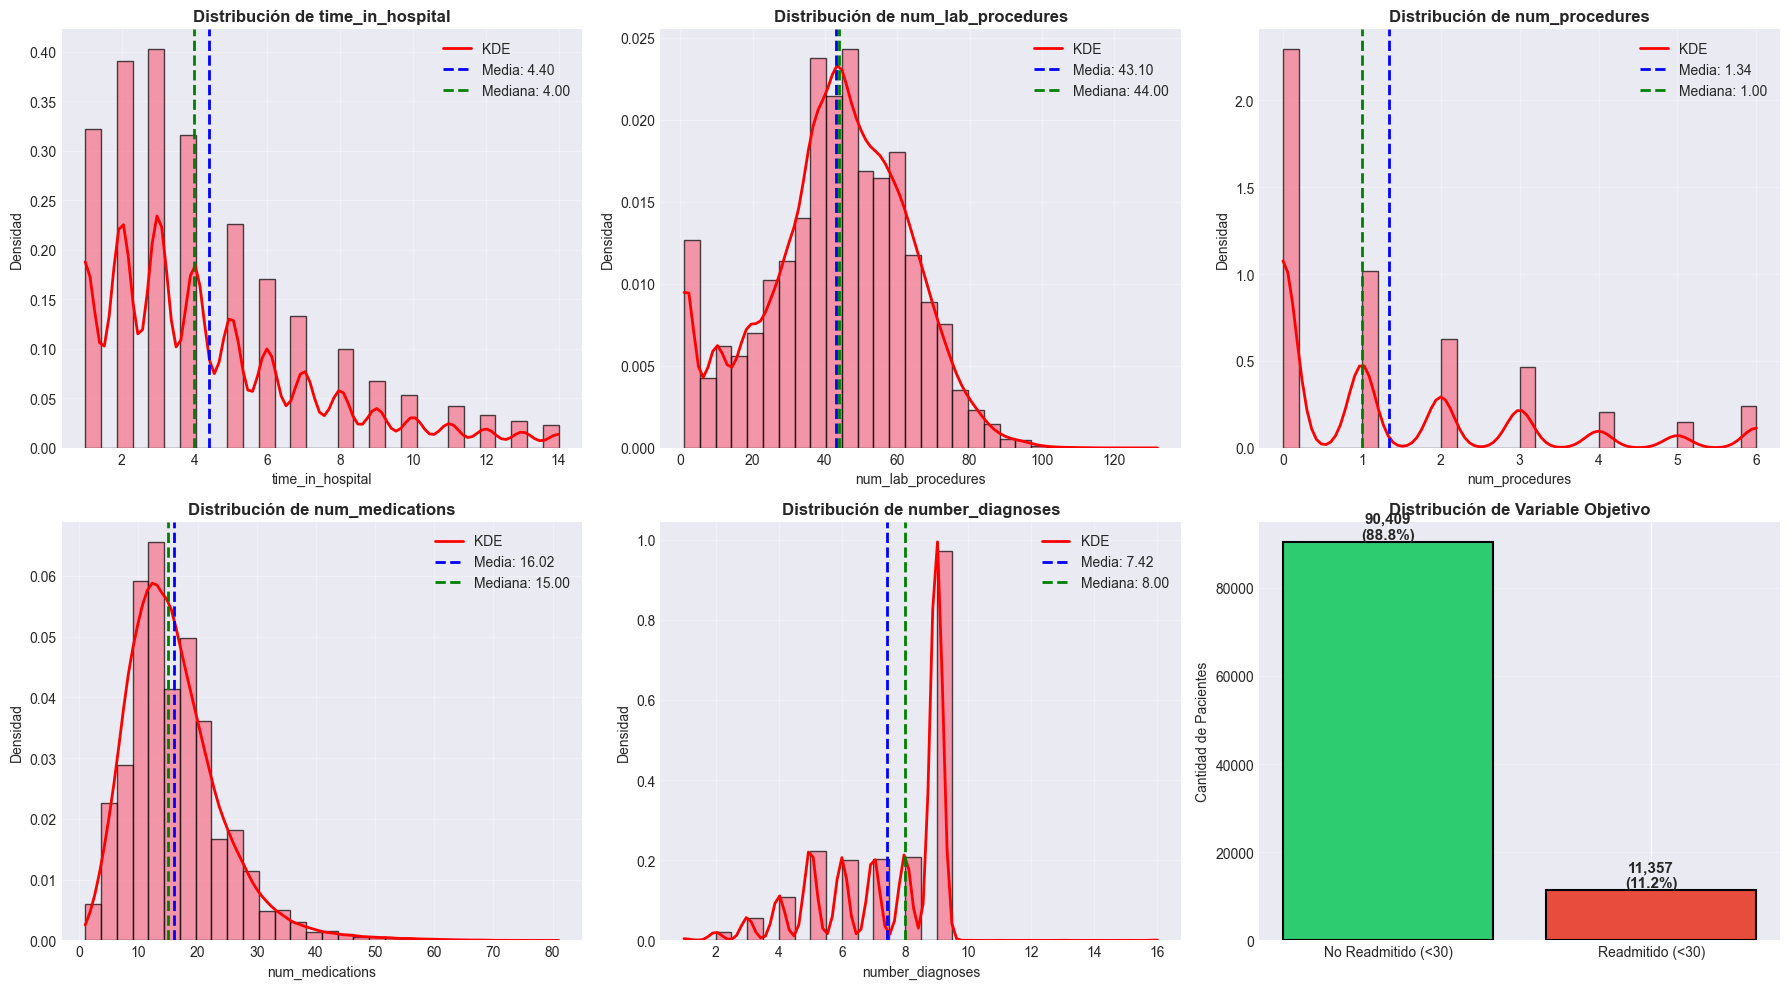

In [24]:
print("\n" + "=" * 80)
print("PARTE 1: ANÁLISIS UNIVARIADO - DISTRIBUCIONES")
print("=" * 80)

# Variables numéricas principales (antes de normalización, las recuperamos del dataset original)
df_original = pd.read_csv("data/diabetic_data.csv")

# Seleccionar variables numéricas clave
numerical_vars = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                  'num_medications', 'number_diagnoses']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, var in enumerate(numerical_vars):
    if var in df_original.columns:
        ax = axes[idx]
        
        # Histograma con KDE
        ax.hist(df_original[var], bins=30, edgecolor='black', alpha=0.7, density=True)
        
        # Curva KDE
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(df_original[var].dropna())
        x_range = np.linspace(df_original[var].min(), df_original[var].max(), 100)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
        
        # Estadísticas
        mean_val = df_original[var].mean()
        median_val = df_original[var].median()
        ax.axvline(mean_val, color='blue', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
        
        ax.set_title(f'Distribución de {var}', fontsize=12, fontweight='bold')
        ax.set_xlabel(var)
        ax.set_ylabel('Densidad')
        ax.legend()
        ax.grid(True, alpha=0.3)

# Gráfico adicional: Distribución de readmitted_binary (ya normalizado)
ax = axes[5]
readmit_counts = df['readmitted_binary'].value_counts().sort_index()
colors = ['#2ecc71', '#e74c3c']
bars = ax.bar(['No Readmitido (<30)', 'Readmitido (<30)'], readmit_counts.values, 
              color=colors, edgecolor='black', linewidth=1.5)

# Añadir porcentajes en las barras
for i, (bar, count) in enumerate(zip(bars, readmit_counts.values)):
    height = bar.get_height()
    pct = (count / len(df)) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Distribución de Variable Objetivo', fontsize=12, fontweight='bold')
ax.set_ylabel('Cantidad de Pacientes')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


**Overview rápido**:
El análisis univariado revela patrones clínicos muy interesantes:
- Primero, observamos que la mayoría de hospitalizaciones son cortas (2-4 días) y conservadoras (0-1 procedimientos), lo que es típico de descompensaciones diabéticas manejadas médicamente. (_fact-checked_)
- Sin embargo, la polifarmacia es evidente: la mediana es de 15 medicamentos, y el promedio de 8 diagnósticos refleja la alta complejidad de estos pacientes.
- Crucialmente, nuestro dataset está significativamente desbalanceado (8:1), con solo el 11% de pacientes readmitidos en menos de 30 días. Esto nos obliga a usar técnicas especializadas como SMOTE y priorizar métricas como Recall sobre Accuracy, ya que los falsos negativos (pacientes en riesgo no detectados) tienen consecuencias graves tanto clínicas como económicas."

### Parte 2: Agregaciones con ``.groupby()``- Análisis bivariado
En esta sección exploramos la **relación entre variables independientes y la readmisión hospitalaria (<30 días)**. El objetivo es identificar qué factores están más fuertemente asociados con el riesgo de readmisión para:

1. **Priorizar features** en el modelado predictivo
2. **Identificar grupos de alto riesgo** para intervenciones clínicas
3. **Validar hipótesis clínicas** con evidencia estadística

PARTE 2: AGREGACIONES CON .groupby() - ANÁLISIS BIVARIADO

🔧 Sincronizando datasets...
✓ Columna 'readmitted_binary' añadida a df_original
✓ Datasets sincronizados: 101,766 filas


--------------------------------------------------------------------------------
2.1 - TASA DE READMISIÓN POR GRUPO DE EDAD
--------------------------------------------------------------------------------
           Readmitidos  Total_Pacientes  Tasa_Readmision  Tasa_Readmision_Pct
age_group                                                                    
[0-10)               3              161           0.0186                 1.86
[10-20)             40              691           0.0579                 5.79
[20-30)            236             1657           0.1424                14.24
[30-40)            424             3775           0.1123                11.23
[40-50)           1027             9685           0.1060                10.60
[50-60)           1668            17256           0.0967            

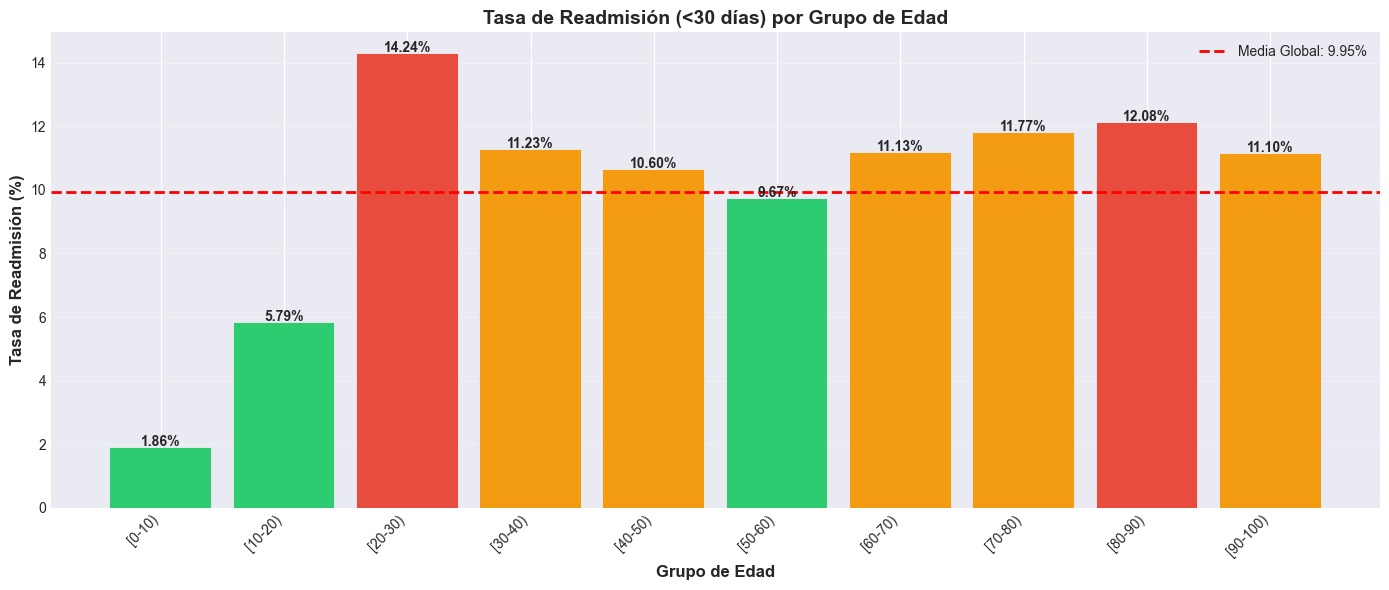


📊 INSIGHT:
   - Grupo con MAYOR tasa de readmisión: [20-30) (14.24%)
   - Grupo con MENOR tasa de readmisión: [0-10) (1.86%)


In [25]:
# ============================================================================
# PARTE 2: AGREGACIONES CON .groupby() - ANÁLISIS BIVARIADO
# ============================================================================

from scipy.stats import mannwhitneyu, chi2_contingency


# Cargar datasets
df = pd.read_csv("data/diabetes_clean.csv")
df_original = pd.read_csv("data/diabetic_data.csv")

print("=" * 80)
print("PARTE 2: AGREGACIONES CON .groupby() - ANÁLISIS BIVARIADO")
print("=" * 80)

# ============================================================================
# PREPARACIÓN: Sincronizar datasets
# ============================================================================
print("\n🔧 Sincronizando datasets...")

if 'readmitted_binary' not in df_original.columns:
    df_original['readmitted_binary'] = df['readmitted_binary'].values
    print("✓ Columna 'readmitted_binary' añadida a df_original")
else:
    print("✓ Columna 'readmitted_binary' ya existe en df_original")

assert len(df_original) == len(df), "ERROR: Los datasets tienen diferente número de filas"
print(f"✓ Datasets sincronizados: {len(df_original):,} filas\n")

# ============================================================================
# 2.1 - TASA DE READMISIÓN POR GRUPO DE EDAD
# ============================================================================
print("\n" + "-" * 80)
print("2.1 - TASA DE READMISIÓN POR GRUPO DE EDAD")
print("-" * 80)

# Mapeo de códigos de edad a etiquetas legibles
age_mapping = {
    0: '[0-10)', 1: '[10-20)', 2: '[20-30)', 3: '[30-40)', 4: '[40-50)',
    5: '[50-60)', 6: '[60-70)', 7: '[70-80)', 8: '[80-90)', 9: '[90-100)'
}

# Crear columna de edad legible
df['age_group'] = df['age'].map(age_mapping)

# Calcular tasa de readmisión por edad
readmit_by_age = df.groupby('age_group').agg({
    'readmitted_binary': ['sum', 'count', 'mean']
}).round(4)

readmit_by_age.columns = ['Readmitidos', 'Total_Pacientes', 'Tasa_Readmision']
readmit_by_age['Tasa_Readmision_Pct'] = (readmit_by_age['Tasa_Readmision'] * 100).round(2)
readmit_by_age = readmit_by_age.sort_index()

print(readmit_by_age)

# Visualización
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

x_pos = np.arange(len(readmit_by_age))
bars = ax.bar(x_pos, readmit_by_age['Tasa_Readmision_Pct'], 
              color='steelblue', edgecolor='black', linewidth=1.5)

# Colorear barras según tasa (rojo si >12%, amarillo si 10-12%, verde si <10%)
for i, (bar, rate) in enumerate(zip(bars, readmit_by_age['Tasa_Readmision_Pct'])):
    if rate > 12:
        bar.set_color('#e74c3c')  # Rojo
    elif rate > 10:
        bar.set_color('#f39c12')  # Amarillo
    else:
        bar.set_color('#2ecc71')  # Verde

# Añadir valores en las barras
for i, (bar, rate) in enumerate(zip(bars, readmit_by_age['Tasa_Readmision_Pct'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Grupo de Edad', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Readmisión (%)', fontsize=12, fontweight='bold')
ax.set_title('Tasa de Readmisión (<30 días) por Grupo de Edad', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(readmit_by_age.index, rotation=45, ha='right')
ax.axhline(y=readmit_by_age['Tasa_Readmision_Pct'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f'Media Global: {readmit_by_age["Tasa_Readmision_Pct"].mean():.2f}%')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



# INSIGHT
max_age = readmit_by_age['Tasa_Readmision_Pct'].idxmax()
min_age = readmit_by_age['Tasa_Readmision_Pct'].idxmin()
print(f"\n📊 INSIGHT:")
print(f"   - Grupo con MAYOR tasa de readmisión: {max_age} ({readmit_by_age.loc[max_age, 'Tasa_Readmision_Pct']:.2f}%)")
print(f"   - Grupo con MENOR tasa de readmisión: {min_age} ({readmit_by_age.loc[min_age, 'Tasa_Readmision_Pct']:.2f}%)")



El grupo de edad **[20-30) presenta la tasa MÁS ALTA de readmisión (14.24%)**, superando incluso a los ancianos de 80-90 años (12.08%). Este resultado es **contrario a lo esperado**.
#### Posibles Explicaciones Clínicas

1. **Diabetes Tipo 1 no controlada**: Más común en jóvenes, puede causar descompensaciones frecuentes (_Dunbar, et. al_)
2. **Menor adherencia al tratamiento**: Pacientes jóvenes pueden tener:
   - Menor conciencia de la gravedad de su condición
   - Dificultades para integrar el manejo de diabetes en su estilo de vida

3. **Barreras socioeconómicas**: 
   - Menor acceso a seguro médico
   - Dificultades para acceder a atención primaria post-alta
   - Falta de recursos para medicamentos


--------------------------------------------------------------------------------
2.2 - TASA DE READMISIÓN POR RAZA Y GÉNERO
--------------------------------------------------------------------------------
                                 Readmitidos  Total    Tasa  Tasa_Pct
race_label      gender_label                                         
AfricanAmerican Female                  1300  11728  0.1108     11.08
                Male                     855   7482  0.1143     11.43
Asian           Female                    24    318  0.0755      7.55
                Male                      41    323  0.1269     12.69
Caucasian       Female                  4651  40822  0.1139     11.39
                Male                    4129  37548  0.1100     11.00
                Unknown/Invalid            0      2  0.0000      0.00
Hispanic        Female                   100   1092  0.0916      9.16
                Male                     112    945  0.1185     11.85
Other           Female  

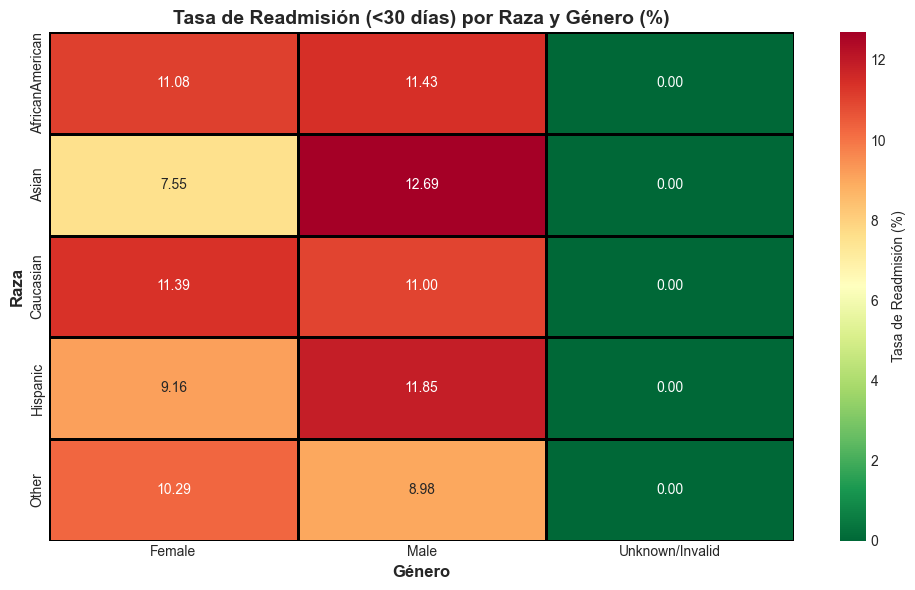


📊 Test Chi-cuadrado: Raza vs Readmisión
   p-value: 0.2301
   ✗ Diferencias NO significativas entre razas

📊 Test Chi-cuadrado: Género vs Readmisión
   p-value: 0.5387
   ✗ Diferencias NO significativas entre géneros


In [26]:
# ============================================================================
# 2.2 - TASA DE READMISIÓN POR RAZA Y GÉNERO
# ============================================================================
print("\n" + "-" * 80)
print("2.2 - TASA DE READMISIÓN POR RAZA Y GÉNERO")
print("-" * 80)

# Mapeo de códigos de raza y género
race_mapping = {0: 'AfricanAmerican', 1: 'Asian', 2: 'Caucasian', 3: 'Hispanic', 4: 'Other'}
gender_mapping = {0: 'Female', 1: 'Male', 2: 'Unknown/Invalid'}

df['race_label'] = df['race'].map(race_mapping)
df['gender_label'] = df['gender'].map(gender_mapping)

# Tabla cruzada: Raza × Género
readmit_by_race_gender = df.groupby(['race_label', 'gender_label']).agg({
    'readmitted_binary': ['sum', 'count', 'mean']
}).round(4)

readmit_by_race_gender.columns = ['Readmitidos', 'Total', 'Tasa']
readmit_by_race_gender['Tasa_Pct'] = (readmit_by_race_gender['Tasa'] * 100).round(2)

print(readmit_by_race_gender)

# Visualización: Heatmap
pivot_table = readmit_by_race_gender['Tasa_Pct'].unstack(fill_value=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=1, linecolor='black', cbar_kws={'label': 'Tasa de Readmisión (%)'}, ax=ax)
ax.set_title('Tasa de Readmisión (<30 días) por Raza y Género (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Género', fontsize=12, fontweight='bold')
ax.set_ylabel('Raza', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


# Test Chi-cuadrado para raza
print("\n📊 Test Chi-cuadrado: Raza vs Readmisión")
contingency_race = pd.crosstab(df['race_label'], df['readmitted_binary'])
chi2_race, pvalue_race, dof_race, expected_race = chi2_contingency(contingency_race)
print(f"   p-value: {pvalue_race:.4f}")
if pvalue_race < 0.05:
    print("   ✓ Diferencias significativas entre razas")
else:
    print("   ✗ Diferencias NO significativas entre razas")

# Test Chi-cuadrado para género
print("\n📊 Test Chi-cuadrado: Género vs Readmisión")
contingency_gender = pd.crosstab(df['gender_label'], df['readmitted_binary'])
chi2_gender, pvalue_gender, dof_gender, expected_gender = chi2_contingency(contingency_gender)
print(f"   p-value: {pvalue_gender:.4f}")
if pvalue_gender < 0.05:
    print("   ✓ Diferencias significativas entre géneros")
else:
    print("   ✗ Diferencias NO significativas entre géneros")





Aunque no son estadísticamente significativas, observamos variaciones moderadas:
- **Rango de tasas por raza**: 7.55% (Asian Female) - 12.69% (Asian Male)
- **Rango de tasas por género**: 8.98% (Other Male) - 11.85% (Hispanic Male)
- **Diferencia máxima**: ~5 puntos porcentuales

La población **Asiática** tiene una muestra pequeña (n=641, 0.6% del total), lo que puede explicar:
- Mayor variabilidad en las tasas (7.55% - 12.69%)
- Menor confiabilidad de las estimaciones
- Posible influencia de outliers



--------------------------------------------------------------------------------
2.3 - TIEMPO DE HOSPITALIZACIÓN SEGÚN READMISIÓN
--------------------------------------------------------------------------------
                         count      mean       std  min  25%  50%  75%   max
readmit_label                                                               
No Readmitido          90409.0  4.349224  2.976382  1.0  2.0  4.0  6.0  14.0
Readmitido (<30 días)  11357.0  4.768249  3.028165  1.0  2.0  4.0  6.0  14.0


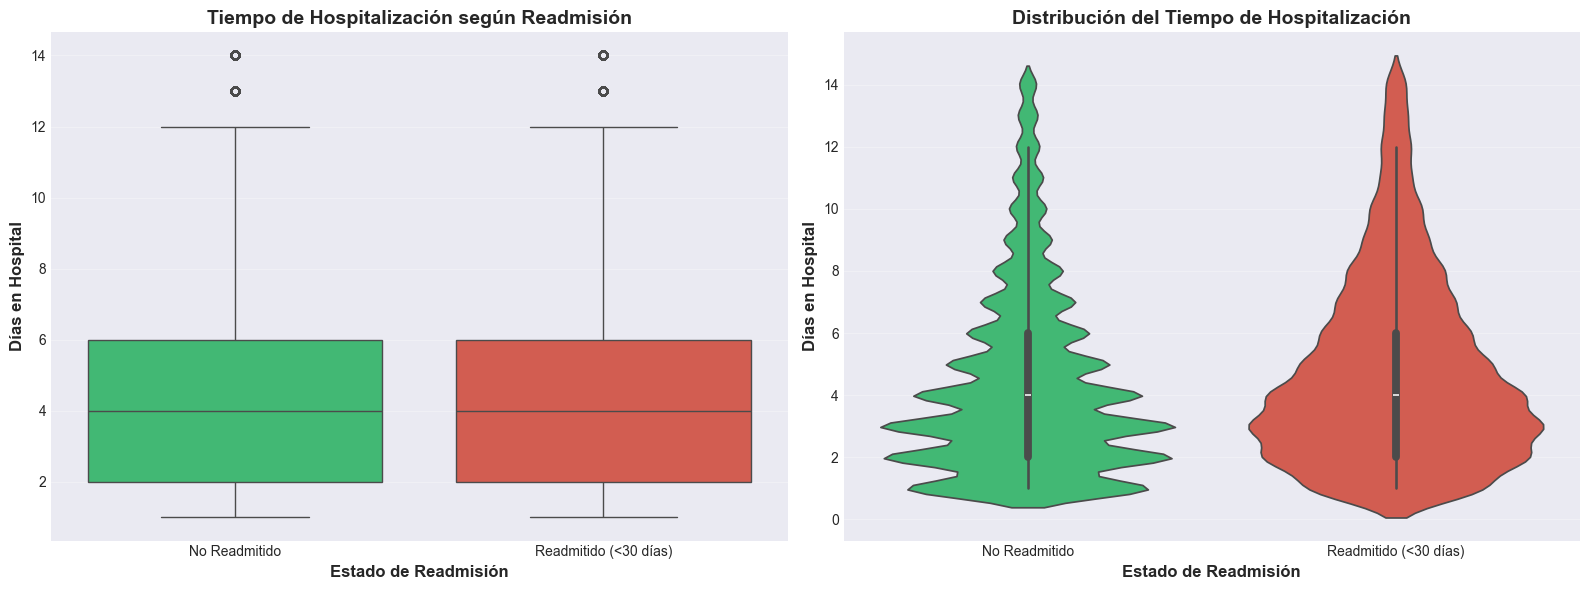


📊 INSIGHT - Test de Mann-Whitney U:
   - Estadístico U: 465881132.00
   - p-value: 2.6896e-59
   ✓ Diferencia ESTADÍSTICAMENTE SIGNIFICATIVA (p < 0.001)
   ⚠️  Pero la diferencia clínica es PEQUEÑA: 0.42 días


In [27]:
# ============================================================================
# 2.3 - TIEMPO DE HOSPITALIZACIÓN SEGÚN READMISIÓN
# ============================================================================
print("\n" + "-" * 80)
print("2.3 - TIEMPO DE HOSPITALIZACIÓN SEGÚN READMISIÓN")
print("-" * 80)

# Añadir label de readmisión a df_original
df_original['readmit_label'] = df['readmitted_binary'].map({0: 'No Readmitido', 1: 'Readmitido (<30 días)'})

time_by_readmit = df_original.groupby('readmit_label')['time_in_hospital'].describe()
print(time_by_readmit)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Boxplot
ax = axes[0]
sns.boxplot(data=df_original, x='readmit_label', y='time_in_hospital', 
            palette=['#2ecc71', '#e74c3c'], ax=ax)
ax.set_title('Tiempo de Hospitalización según Readmisión', fontsize=14, fontweight='bold')
ax.set_xlabel('Estado de Readmisión', fontsize=12, fontweight='bold')
ax.set_ylabel('Días en Hospital', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Subplot 2: Violinplot
ax = axes[1]
sns.violinplot(data=df_original, x='readmit_label', y='time_in_hospital', 
               palette=['#2ecc71', '#e74c3c'], ax=ax)
ax.set_title('Distribución del Tiempo de Hospitalización', fontsize=14, fontweight='bold')
ax.set_xlabel('Estado de Readmisión', fontsize=12, fontweight='bold')
ax.set_ylabel('Días en Hospital', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



# Test estadístico
group_0 = df_original[df_original['readmitted_binary'] == 0]['time_in_hospital']
group_1 = df_original[df_original['readmitted_binary'] == 1]['time_in_hospital']
statistic, pvalue = mannwhitneyu(group_0, group_1, alternative='two-sided')

print(f"\n📊 INSIGHT - Test de Mann-Whitney U:")
print(f"   - Estadístico U: {statistic:.2f}")
print(f"   - p-value: {pvalue:.4e}")
if pvalue < 0.001:
    print(f"   ✓ Diferencia ESTADÍSTICAMENTE SIGNIFICATIVA (p < 0.001)")
    print(f"   ⚠️  Pero la diferencia clínica es PEQUEÑA: {time_by_readmit.loc['Readmitido (<30 días)', 'mean'] - time_by_readmit.loc['No Readmitido', 'mean']:.2f} días")
else:
    print(f"   ✗ Sin diferencia significativa")

| Aspecto | Resultado |
|---------|-----------|
| **Diferencia observada** | 0.42 días (~10 horas) |
| **Significancia estadística** | p < 0.001 (SÍ significativo) |
| **Relevancia clínica** | BAJA (diferencia pequeña) |

Con una muestra de **101,766 pacientes**, incluso diferencias **muy pequeñas** resultan estadísticamente significativas debido al alto poder estadístico. Sin embargo, una diferencia de **medio día de estancia** es clínicamente trivial.

Los boxplots y violinplots muestran:
- **Misma mediana**: 4 días en ambos grupos
- **Mismo rango intercuartílico**: 2-6 días
- **Distribuciones muy superpuestas**: La mayoría de pacientes tiene 2-6 días independientemente de si fueron readmitidos


**El tiempo de hospitalización por sí solo NO es un predictor fuerte**, pero puede interactuar con otras variables:
- Estancias **muy cortas** (<2 días): ¿Estamos hablando de un alta prematura?
- Estancias **muy largas** (>10 días): Indicador de complicaciones


--------------------------------------------------------------------------------
2.4 - NÚMERO DE MEDICAMENTOS Y READMISIÓN
--------------------------------------------------------------------------------
                     Readmitidos  Total      Tasa  Tasa_Pct
num_medications_bin                                        
1-10                        2344  25861  0.090638      9.06
11-15                       3206  29384  0.109107     10.91
16-20                       2756  22641  0.121726     12.17
21-25                       1627  12521  0.129942     12.99
>25                         1424  11359  0.125363     12.54


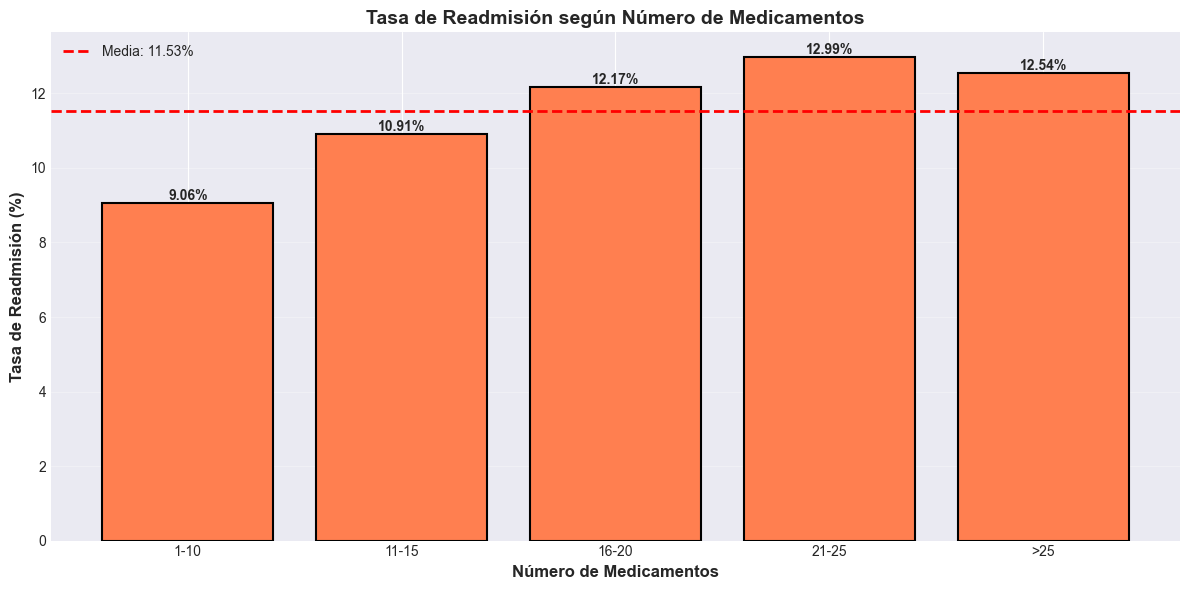


📊 INSIGHT:
   - Incremento de riesgo: 43.4% (de 9.06% a 12.99%)
   - Tendencia: MONOTÓNICA CRECIENTE (a más medicamentos → mayor riesgo)
   - Umbral crítico: >15 medicamentos (tasa >12%)


In [28]:
# ============================================================================
# 2.4 - NÚMERO DE MEDICAMENTOS Y READMISIÓN
# ============================================================================
print("\n" + "-" * 80)
print("2.4 - NÚMERO DE MEDICAMENTOS Y READMISIÓN")
print("-" * 80)

# Crear DataFrame temporal
df_temp_meds = pd.DataFrame({
    'num_medications': df_original['num_medications'],
    'readmitted_binary': df['readmitted_binary']
})

# Crear bins de medicamentos
df_temp_meds['num_medications_bin'] = pd.cut(df_temp_meds['num_medications'], 
                                              bins=[0, 10, 15, 20, 25, 100],
                                              labels=['1-10', '11-15', '16-20', '21-25', '>25'])

readmit_by_meds = df_temp_meds.groupby('num_medications_bin').agg({
    'readmitted_binary': ['sum', 'count', 'mean']
})
readmit_by_meds.columns = ['Readmitidos', 'Total', 'Tasa']
readmit_by_meds['Tasa_Pct'] = (readmit_by_meds['Tasa'] * 100).round(2)

print(readmit_by_meds)

# Visualización
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x_pos = np.arange(len(readmit_by_meds))
bars = ax.bar(x_pos, readmit_by_meds['Tasa_Pct'], color='coral', edgecolor='black', linewidth=1.5)

for i, (bar, rate) in enumerate(zip(bars, readmit_by_meds['Tasa_Pct'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{rate:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Número de Medicamentos', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Readmisión (%)', fontsize=12, fontweight='bold')
ax.set_title('Tasa de Readmisión según Número de Medicamentos', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(readmit_by_meds.index)
ax.axhline(y=readmit_by_meds['Tasa_Pct'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f'Media: {readmit_by_meds["Tasa_Pct"].mean():.2f}%')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



# Análisis de tendencia
print(f"\n📊 INSIGHT:")
min_rate = readmit_by_meds['Tasa_Pct'].min()
max_rate = readmit_by_meds['Tasa_Pct'].max()
diff_pct = ((max_rate - min_rate) / min_rate) * 100
print(f"   - Incremento de riesgo: {diff_pct:.1f}% (de {min_rate:.2f}% a {max_rate:.2f}%)")
print(f"   - Tendencia: MONOTÓNICA CRECIENTE (a más medicamentos → mayor riesgo)")
print(f"   - Umbral crítico: >15 medicamentos (tasa >12%)")

| Medicamentos | Tasa Readmisión | Incremento vs Baseline | Interpretación |
|--------------|-----------------|------------------------|----------------|
| 1-10 | 9.06% | — | Baseline (casos simples) |
| 11-15 | 10.91% | +20% | Complejidad moderada |
| 16-20 | 12.17% | +34% | Alta complejidad |
| **21-25** | **12.99%** | **+43%** | Riesgo máximo |
| >25 | 12.54% | +38% | Ligera disminución (plateau) |


El número de medicamentos refleja:

1. **Carga de comorbilidades**: Más enfermedades crónicas = más fármacos
2. **Fragilidad del paciente**: Múltiples sistemas afectados
3. **Riesgo de interacciones**: A más fármacos, mayor probabilidad de:
   - Interacciones medicamentosas
   - Efectos adversos
   - Errores de administración
4. **Menor adherencia**: La complejidad del régimen terapéutico dificulta el cumplimiento

#### ¿Por qué disminuye levemente en el caso de pacientes con >25 medicamentos?

Posibles explicaciones:
- **Sesgo de supervivencia**: Pacientes muy complejos pero bajo manejo especializado intensivo
- **Mayor vigilancia**: Casos con >25 fármacos probablemente tienen seguimiento por múltiples especialistas
- **Muestra más pequeña**: Solo 11,359 pacientes (11%) con >25 medicamentos

#### Umbral Crítico Identificado: >15 Medicamentos

Pacientes con **más de 15 medicamentos** cruzan un umbral de riesgo:
- Tasa salta de 10.91% → 12.17% (+11.5%)
- Se mantiene elevada hasta >25
- **Recomendación clínica**: Priorizar seguimiento farmacoterapéutico


## Parte 3: Matriz de Correlación

**Observamos varias cosas**<br><br>
- **Ninguna variable individual tiene correlación lineal fuerte con readmisión** (todas <0.20). Esto indica:

    1.  **La readmisión es un fenómeno multifactorial**: No existe un único predictor dominante
    2.  **Relaciones no lineales**: Variables como `num_medications` y `age` mostraron patrones claros en análisis bivariado pero correlación lineal débil
    3.  **Interacciones complejas**: El riesgo de readmisión depende de combinaciones de factores, no de variables aisladas



- `total_visits` es la **suma** de sus componentes:
    ```python
    total_visits = number_inpatient + number_emergency + number_outpatient
    ```
De allí la alta correlación.

- #### Correlaciones Esperadas (Coherencia Clínica)

| Par de Variables | r | Interpretación |
|------------------|---|----------------|
| **time_in_hospital ↔ num_medications** | **0.47** | Estancias largas → Más medicamentos (complejidad) |
| **time_in_hospital ↔ num_procedures** | **0.19** | Estancias largas → Más procedimientos |
| **time_in_hospital ↔ num_lab_procedures** | **0.32** | Estancias largas → Más laboratorios |
| **num_medications ↔ num_procedures** | **0.39** | Más procedimientos → Más fármacos |
| **num_medications ↔ number_diagnoses** | **0.26** | Más diagnósticos → Más medicamentos |

✅ **Estas correlaciones son esperables** y reflejan la **complejidad clínica** de forma coherente. No representan un problema de multicolinealidad grave (<0.50).


---




## Parte 4: Análisis adicional


PARTE 4: ANÁLISIS ADICIONALES

--------------------------------------------------------------------------------
4.1 - TOP 10 CATEGORÍAS DE DIAGNÓSTICO PRIMARIO (ICD-9)
--------------------------------------------------------------------------------


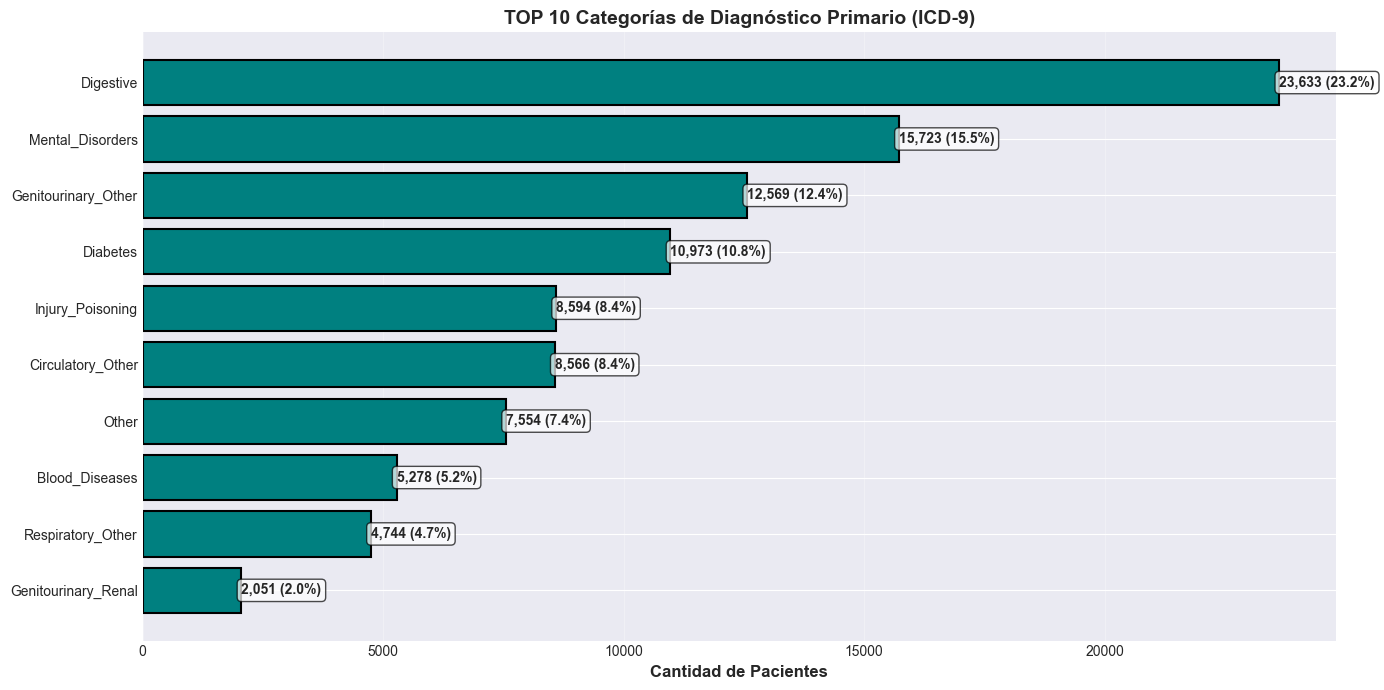


--------------------------------------------------------------------------------
4.2 - TASA DE READMISIÓN POR DIAGNÓSTICO PRIMARIO
--------------------------------------------------------------------------------
                     Readmitidos  Total      Tasa  Tasa_Pct
diag_1_label                                               
Blood_Diseases               690   5278  0.130731     13.07
Genitourinary_Other         1529  12569  0.121649     12.16
Respiratory_Other            576   4744  0.121417     12.14
Injury_Poisoning            1032   8594  0.120084     12.01
Genitourinary_Renal          237   2051  0.115553     11.56
Circulatory_Other            949   8566  0.110787     11.08
Digestive                   2598  23633  0.109931     10.99
Mental_Disorders            1610  15723  0.102398     10.24
Diabetes                    1122  10973  0.102251     10.23
Other                        716   7554  0.094784      9.48


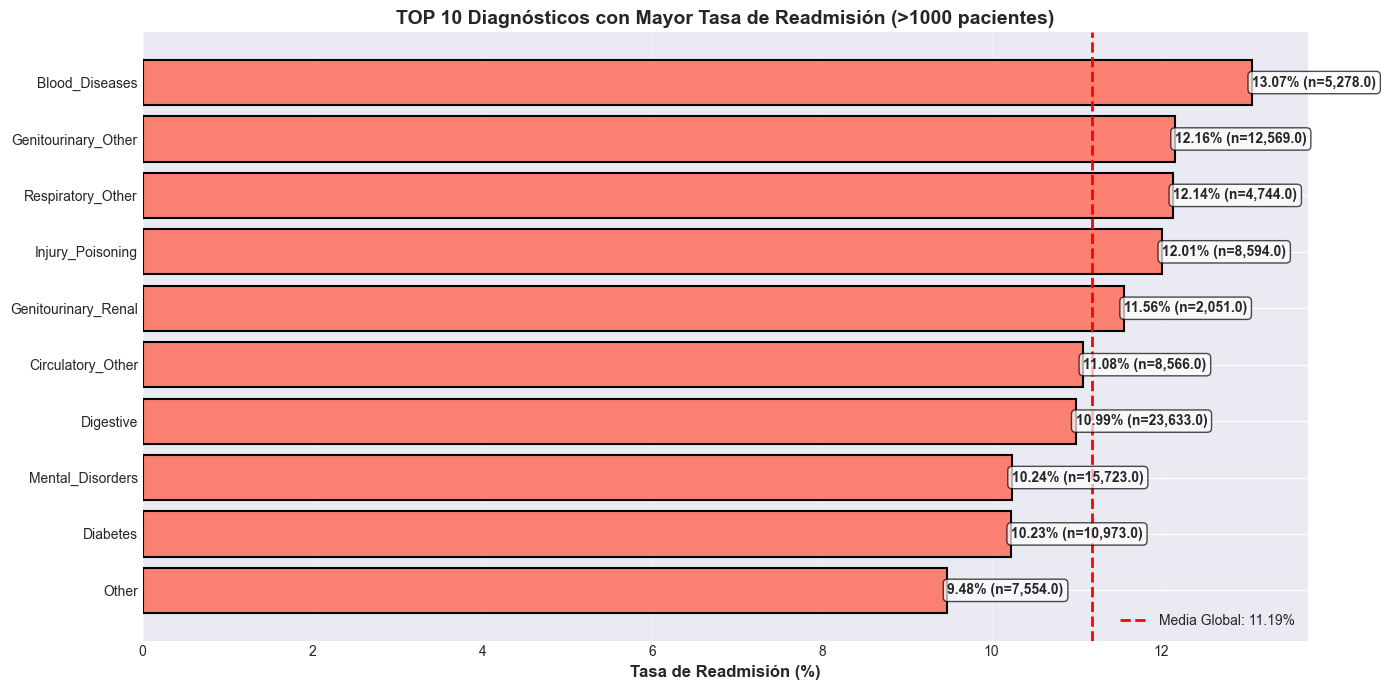


--------------------------------------------------------------------------------
4.3 - USO DE INSULINA Y READMISIÓN
--------------------------------------------------------------------------------
               Readmitidos  Total      Tasa  Tasa_Pct
insulin_label                                        
Down                  1698  12218  0.138975     13.90
No                    4756  47383  0.100374     10.04
Steady                3433  30849  0.111284     11.13
Up                    1470  11316  0.129905     12.99


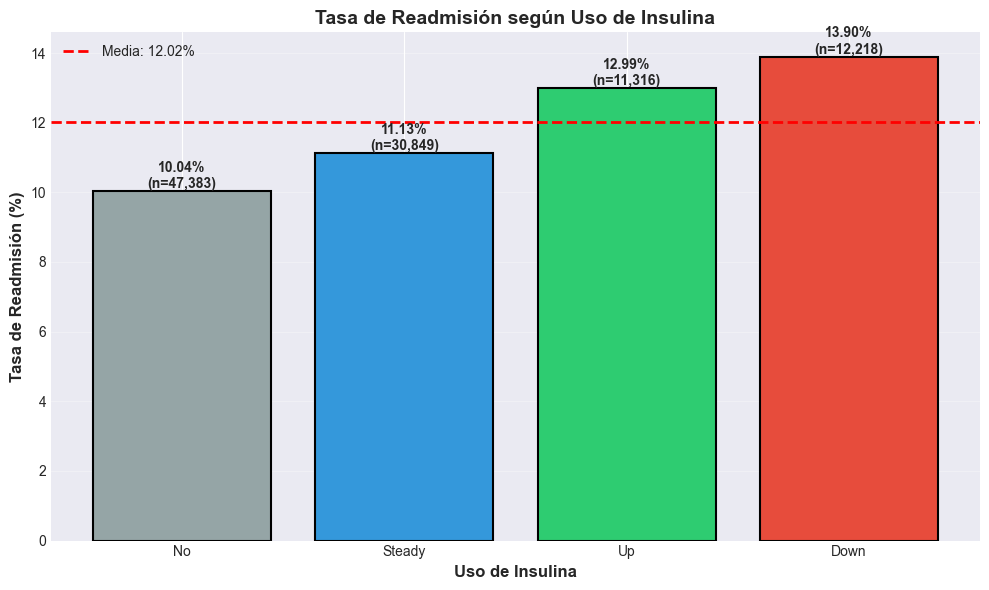


✅ PARTE 4 COMPLETADA


In [29]:
print("\n" + "=" * 80)
print("PARTE 4: ANÁLISIS ADICIONALES")
print("=" * 80)

# ============================================================================
# 4.1 - DISTRIBUCIÓN DE DIAGNÓSTICOS (TOP 10 CATEGORÍAS ICD-9)
# ============================================================================
print("\n" + "-" * 80)
print("4.1 - TOP 10 CATEGORÍAS DE DIAGNÓSTICO PRIMARIO (ICD-9)")
print("-" * 80)

# Mapeo de categorías ICD-9
diag_mapping = {
    0: 'Blood_Diseases', 1: 'Circulatory_Heart_Failure', 2: 'Circulatory_Ischemic_Heart',
    3: 'Circulatory_Other', 4: 'Congenital_Anomalies', 5: 'Diabetes',
    6: 'Digestive', 7: 'Endocrine_Metabolic', 8: 'External_Causes',
    9: 'Genitourinary_Other', 10: 'Genitourinary_Renal', 11: 'Infectious_Parasitic',
    12: 'Injury_Poisoning', 13: 'Mental_Disorders', 14: 'Musculoskeletal',
    15: 'Neoplasms', 16: 'Nervous_Sense', 17: 'Other', 18: 'Respiratory_COPD',
    19: 'Respiratory_Other', 20: 'Respiratory_Pneumonia', 21: 'Skin_Subcutaneous',
    22: 'Symptoms_Signs', 23: 'Unknown'
}

# Verificar si existe diag_1_category
if 'diag_1_category' in df.columns:
    df['diag_1_label'] = df['diag_1_category'].map(diag_mapping)
    
    top_diag = df['diag_1_label'].value_counts().head(10)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    bars = ax.barh(top_diag.index, top_diag.values, color='teal', edgecolor='black', linewidth=1.5)
    
    for i, (bar, val) in enumerate(zip(bars, top_diag.values)):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{val:,} ({(val/len(df)*100):.1f}%)',
                ha='left', va='center', fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Cantidad de Pacientes', fontsize=12, fontweight='bold')
    ax.set_title('TOP 10 Categorías de Diagnóstico Primario (ICD-9)', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    
# ============================================================================
# 4.2 - READMISIÓN POR DIAGNÓSTICO PRIMARIO (TOP 10)
# ============================================================================
print("\n" + "-" * 80)
print("4.2 - TASA DE READMISIÓN POR DIAGNÓSTICO PRIMARIO")
print("-" * 80)

if 'diag_1_label' in df.columns:
    readmit_by_diag = df.groupby('diag_1_label').agg({
        'readmitted_binary': ['sum', 'count', 'mean']
    })
    readmit_by_diag.columns = ['Readmitidos', 'Total', 'Tasa']
    readmit_by_diag['Tasa_Pct'] = (readmit_by_diag['Tasa'] * 100).round(2)
    
    # Filtrar diagnósticos con al menos 1000 pacientes
    readmit_by_diag_filtered = readmit_by_diag[readmit_by_diag['Total'] >= 1000].sort_values('Tasa_Pct', ascending=False).head(10)
    
    print(readmit_by_diag_filtered)
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    bars = ax.barh(readmit_by_diag_filtered.index, readmit_by_diag_filtered['Tasa_Pct'], 
                   color='salmon', edgecolor='black', linewidth=1.5)
    
    for i, (bar, rate) in enumerate(zip(bars, readmit_by_diag_filtered['Tasa_Pct'])):
        width = bar.get_width()
        total = readmit_by_diag_filtered.iloc[i]['Total']
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{rate:.2f}% (n={total:,})',
                ha='left', va='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax.set_xlabel('Tasa de Readmisión (%)', fontsize=12, fontweight='bold')
    ax.set_title('TOP 10 Diagnósticos con Mayor Tasa de Readmisión (>1000 pacientes)', 
                 fontsize=14, fontweight='bold')
    ax.axvline(x=readmit_by_diag['Tasa_Pct'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f'Media Global: {readmit_by_diag["Tasa_Pct"].mean():.2f}%')
    ax.legend()
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    

# ============================================================================
# 4.3 - USO DE INSULINA Y READMISIÓN
# ============================================================================
print("\n" + "-" * 80)
print("4.3 - USO DE INSULINA Y READMISIÓN")
print("-" * 80)

# Mapeo de insulin
insulin_mapping = {0: 'Down', 1: 'No', 2: 'Steady', 3: 'Up'}

if 'insulin' in df.columns:
    df['insulin_label'] = df['insulin'].map(insulin_mapping)
    
    readmit_by_insulin = df.groupby('insulin_label').agg({
        'readmitted_binary': ['sum', 'count', 'mean']
    })
    readmit_by_insulin.columns = ['Readmitidos', 'Total', 'Tasa']
    readmit_by_insulin['Tasa_Pct'] = (readmit_by_insulin['Tasa'] * 100).round(2)
    
    print(readmit_by_insulin)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    colors_insulin = {'No': '#95a5a6', 'Steady': '#3498db', 'Up': '#2ecc71', 'Down': '#e74c3c'}
    order = ['No', 'Steady', 'Up', 'Down']
    order = [o for o in order if o in readmit_by_insulin.index]
    
    bars = ax.bar(order, [readmit_by_insulin.loc[o, 'Tasa_Pct'] for o in order],
                  color=[colors_insulin.get(x, 'steelblue') for x in order],
                  edgecolor='black', linewidth=1.5)
    
    for bar, label in zip(bars, order):
        height = bar.get_height()
        total = readmit_by_insulin.loc[label, 'Total']
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%\n(n={total:,})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Uso de Insulina', fontsize=12, fontweight='bold')
    ax.set_ylabel('Tasa de Readmisión (%)', fontsize=12, fontweight='bold')
    ax.set_title('Tasa de Readmisión según Uso de Insulina', fontsize=14, fontweight='bold')
    ax.axhline(y=readmit_by_insulin['Tasa_Pct'].mean(), color='red',
               linestyle='--', linewidth=2, label=f'Media: {readmit_by_insulin["Tasa_Pct"].mean():.2f}%')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    



print("\n" + "=" * 80)
print("✅ PARTE 4 COMPLETADA")
print("=" * 80)

<div align="center">

# ROBERT

</div>

# Modelado y Clasificación

En esta fase abordamos el problema de clasificación binaria para predecir si un paciente será readmitido en el hospital en menos de 30 días. 

Dado el **desbalance de clases** identificado previamente (~11% de readmisiones), utilizaremos la estrategia `class_weight='balanced'` en los siguentes modelos "clásicos". Esta técnica ajusta automáticamente los pesos de las clases de forma inversamente proporcional a su frecuencia, lo que permite al algoritmo "prestar más atención" a la clase minoritaria sin necesidad de técnicas de remuestreo.

## Preparación de datos para el modelado

Antes de entrenar cualquier modelo, preparamos los datos siguiendo estos pasos:

1. **Definición de features (X) y target (y):** separamos la variable objetivo `readmitted_binary` de las predictoras, eliminando identificadores y columnas redundantes.
2. **Codificación (One-Hot encoding):** convertimos variables categóricas a numéricas con `get_dummies`.
3. **División train/test (80/20):** utilizamos `stratify=y` para mantener la proporción de clases en ambos conjuntos.

In [30]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Columnas a excluir (identificadores, target y columnas redundantes)
cols_to_exclude = [          
    'readmitted_binary',         
    'readmit_label',                           
    'insulin_label', 'num_medications_bin',    
    'diag_1_label',
    'procedures_per_day', 'total_visits',
]

existing_cols_to_drop = [c for c in cols_to_exclude if c in df.columns]
X = df.drop(columns=existing_cols_to_drop)
y = df['readmitted_binary']

# Codificación One-Hot
X = pd.get_dummies(X, drop_first=True)

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Dimensiones - train: {X_train.shape} | test: {X_test.shape}")
print(f"Proporción readmitidos - train: {y_train.mean():.2%} | test: {y_test.mean():.2%}")

Dimensiones - train: (81412, 78) | test: (20354, 78)
Proporción readmitidos - train: 11.16% | test: 11.16%


La división mantiene la proporción original de clases (~11% readmitidos) tanto en train como en test, gracias al parámetro `stratify`. Esto es crucial para una evaluación realista del modelo.

Esto es **lo que necesitamos**, porque:

1. Se realiza una evaluación realista: el test set refleja la misma distribución que encontrarás en producción
2. Evita sesgos: sin stratify, podrías tener por azar 15% de readmitidos en train y 8% en test, lo que distorsionaría las métricas
3. Alta reproducibilidad: cada partición es representativa del problema real

## Regresión Logística (Baseline)

Comenzamos con **Regresión Logística** como modelo baseline por su simplicidad e interpretabilidad. Este modelo lineal estima la probabilidad de readmisión basándose en una combinación ponderada de las features.

### Entrenamiento y configuración visual

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuración de estilo para gráficas
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': '#f8f9fa',
    'axes.edgecolor': '#333333',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# Paleta de colores
COLORS = {
    'primary': '#2E86AB', 'secondary': '#A23B72', 'success': '#28A745',
    'danger': '#DC3545', 'warning': '#FFC107', 'info': '#17A2B8', 'dark': '#343A40'
}

# Entrenamiento del modelo
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


El output que vemos tras ejecutar `log_reg.fit(X_train, y_train)` es simplemente la representación del objetivo del modelo.

¿Qué significa cada parámetro?

| Parámetro | Valor | Significado |
| :--- | :--- | :--- |
| `class_weight='balanced'` | `'balanced'` | Ajusta automáticamente los pesos para compensar el desbalance de clases (89% vs 11%) |
| `max_iter=1000` | `1000` | Número máximo de iteraciones para que el algoritmo converja |
| `n_jobs=-1` | `-1` | Usa todos los núcleos del CPU disponibles para paralelizar |
| `random_state=42` | `42` | Semilla para reproducibilidad |

### Validación cruzada

Evaluamos la estabilidad del modelo con validación cruzada de 5 particiones. Esto nos da una estimación más robusta del rendimiento que una simple división train/test.

In [32]:
cv_scores_acc = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_f1 = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='f1')
cv_scores_recall = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='recall')

print(f"Accuracy:  {cv_scores_acc.mean():.4f} ± {cv_scores_acc.std():.4f}")
print(f"F1-Score:  {cv_scores_f1.mean():.4f} ± {cv_scores_f1.std():.4f}")
print(f"Recall:    {cv_scores_recall.mean():.4f} ± {cv_scores_recall.std():.4f}")

Accuracy:  0.6614 ± 0.0039
F1-Score:  0.2532 ± 0.0014
Recall:    0.5144 ± 0.0066


Los resultados muestran baja variabilidad entre folds (desviaciones estándar pequeñas), lo que indica que el modelo es estable. El F1-Score de ~0.25 y recall de ~0.51 reflejan las dificultades inherentes a predecir readmisiones, un problema conocido por su complejidad.

### Evaluación en test set y matriz de confusión

               precision    recall  f1-score   support

No Readmitido       0.92      0.68      0.78     18083
   Readmitido       0.17      0.53      0.26      2271

     accuracy                           0.66     20354
    macro avg       0.55      0.60      0.52     20354
 weighted avg       0.84      0.66      0.72     20354



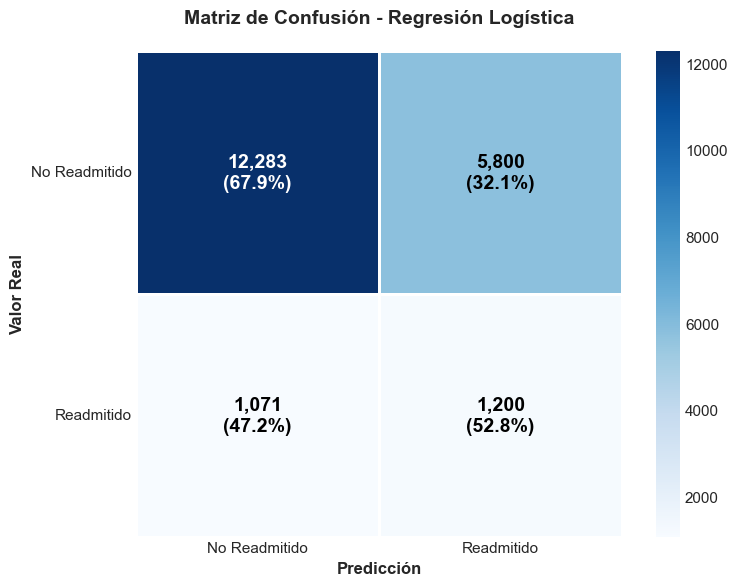

In [33]:
# Predicciones en test
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_log, target_names=['No Readmitido', 'Readmitido']))

# Matriz de Confusión
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_log)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

sns.heatmap(cm, annot=False, cmap='Blues', cbar=True, ax=ax, linewidths=2, linecolor='white', square=True)
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        ax.text(j + 0.5, i + 0.5, f'{cm[i,j]:,}\n({cm_pct[i,j]:.1f}%)', 
                ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

ax.set_xlabel('Predicción', fontsize=12, fontweight='bold')
ax.set_ylabel('Valor Real', fontsize=12, fontweight='bold')
ax.set_xticklabels(['No Readmitido', 'Readmitido'], fontsize=11)
ax.set_yticklabels(['No Readmitido', 'Readmitido'], fontsize=11, rotation=0)
ax.set_title('Matriz de Confusión - Regresión Logística', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

**Interpretación de la matriz:**
- **Verdaderos negativos (12,283):** pacientes no readmitidos correctamente clasificados
- **Falsos positivos (5,800):** pacientes no readmitidos clasificados erróneamente como readmitidos
- **Falsos negativos (1,071):** pacientes readmitidos que el modelo no detectó (los más críticos en contexto médico)
- **Verdaderos positivos (1,200):** pacientes readmitidos correctamente identificados

El modelo detecta aproximadamente el 53% de los readmitidos (recall), pero con una precisión baja (17%), generando muchos falsos positivos.

### Análisis de umbral de decisión

Por defecto, clasificamos como positivo cuando P(readmitido) > 0.5. En datos desbalanceados, ajustar este umbral puede mejorar el balance entre precisión y recall.

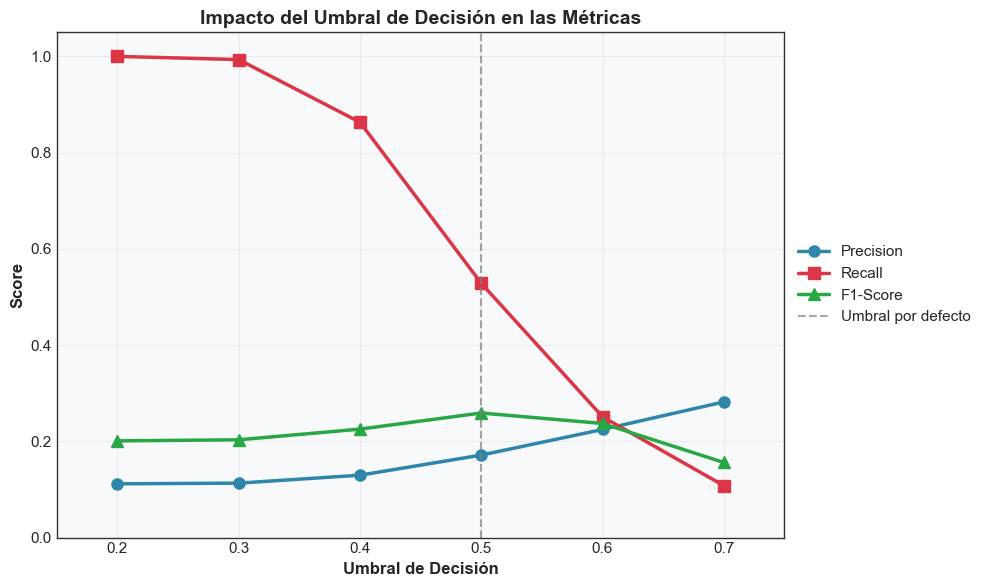

In [34]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
results_thresh = []

for thresh in thresholds:
    y_pred_thresh = (y_prob_log >= thresh).astype(int)
    report = classification_report(y_test, y_pred_thresh, output_dict=True, zero_division=0)
    results_thresh.append({
        'Umbral': thresh, 'Precision': report['1']['precision'],
        'Recall': report['1']['recall'], 'F1-Score': report['1']['f1-score']
    })

# Gráfica
fig, ax = plt.subplots(figsize=(10, 6))
precisions = [r['Precision'] for r in results_thresh]
recalls = [r['Recall'] for r in results_thresh]
f1_scores = [r['F1-Score'] for r in results_thresh]

ax.plot(thresholds, precisions, 'o-', color=COLORS['primary'], linewidth=2.5, markersize=8, label='Precision')
ax.plot(thresholds, recalls, 's-', color=COLORS['danger'], linewidth=2.5, markersize=8, label='Recall')
ax.plot(thresholds, f1_scores, '^-', color=COLORS['success'], linewidth=2.5, markersize=8, label='F1-Score')
ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Umbral por defecto')

ax.set_xlabel('Umbral de Decisión', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Impacto del Umbral de Decisión en las Métricas', fontsize=14, fontweight='bold')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0.15, 0.75)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Observaciones:**
- Con umbral **bajo (0.2-0.3)**: recall cercano al 100% (detectamos casi todos los readmitidos), pero Precision muy baja (~11%)
- Con umbral **alto (0.6-0.7)**: precision aumenta (~29%) pero recall cae drásticamente (~11%)
- El umbral **0.5** ofrece un compromiso razonable con el mejor F1-Score

En contexto médico, podría preferirse un umbral más bajo para no dejar escapar pacientes en riesgo.

### Curva ROC y AUC

La **Curva ROC (Receiver Operating Characteristic)** es una representación gráfica que ilustra la capacidad de diagnóstico de un sistema clasificador binario a medida que se varía su umbral de discriminación.

*   **Eje Y (Sensibilidad o TPR):** representa la tasa de verdaderos positivos. ¿Qué porcentaje de los pacientes realmente readmitidos fuimos capaces de detectar?
*   **Eje X (1 - Especificidad o FPR):** representa la tasa de falsos positivos. ¿Qué porcentaje de pacientes sanos (no readmitidos) clasificamos erróneamente como en riesgo?

El **AUC (Area Under the Curve)** es el área bajo esta curva y proporciona una métrica única para comparar modelos:
*   **0.5:** predicción aleatoria (sin valor).
*   **0.7 - 0.8:** rendimiento aceptable.
*   **> 0.8:** rendimiento excelente.

Un AUC de **0.645** (como veremos abajo) significa que si tomamos un paciente readmitido y uno no readmitido al azar, el modelo clasificará correctamente al readmitido con mayor probabilidad el 64.5% de las veces.

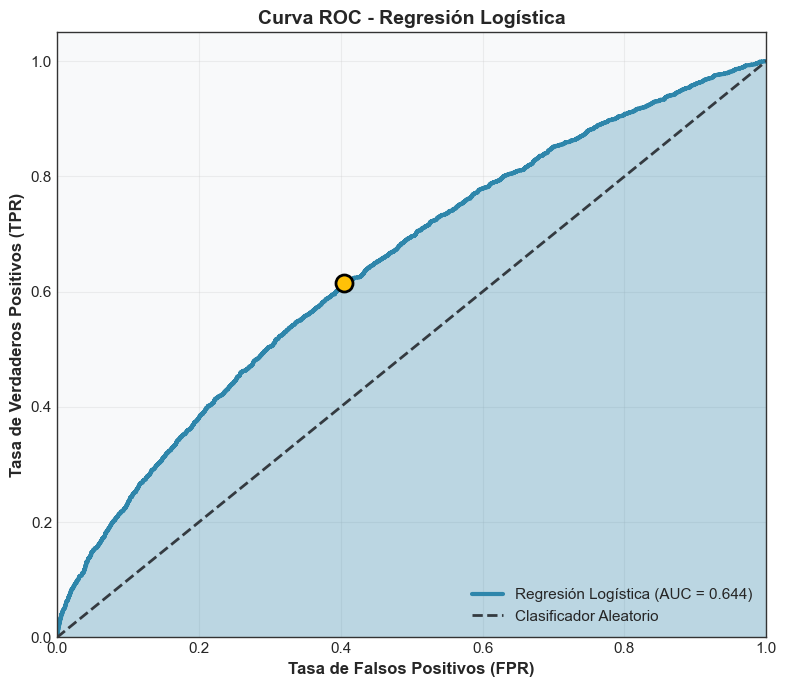

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_prob_log)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 7))
ax.fill_between(fpr, tpr, alpha=0.3, color=COLORS['primary'])
ax.plot(fpr, tpr, color=COLORS['primary'], lw=3, label=f'Regresión Logística (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], color=COLORS['dark'], lw=2, linestyle='--', label='Clasificador Aleatorio')

optimal_idx = np.argmax(tpr - fpr)
ax.scatter(fpr[optimal_idx], tpr[optimal_idx], s=150, c=COLORS['warning'], edgecolors='black', linewidths=2, zorder=5)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12, fontweight='bold')
ax.set_title('Curva ROC - Regresión Logística', fontsize=14, fontweight='bold')
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

El **AUC de 0.644** indica capacidad discriminativa moderada (superior al azar = 0.5 pero lejos de un clasificador perfecto = 1.0). El punto amarillo marca el umbral óptimo según el estadístico de Youden (máximo TPR - FPR).

### Importancia de Features

Los coeficientes del modelo nos indican qué variables tienen mayor influencia en la predicción de readmisión.

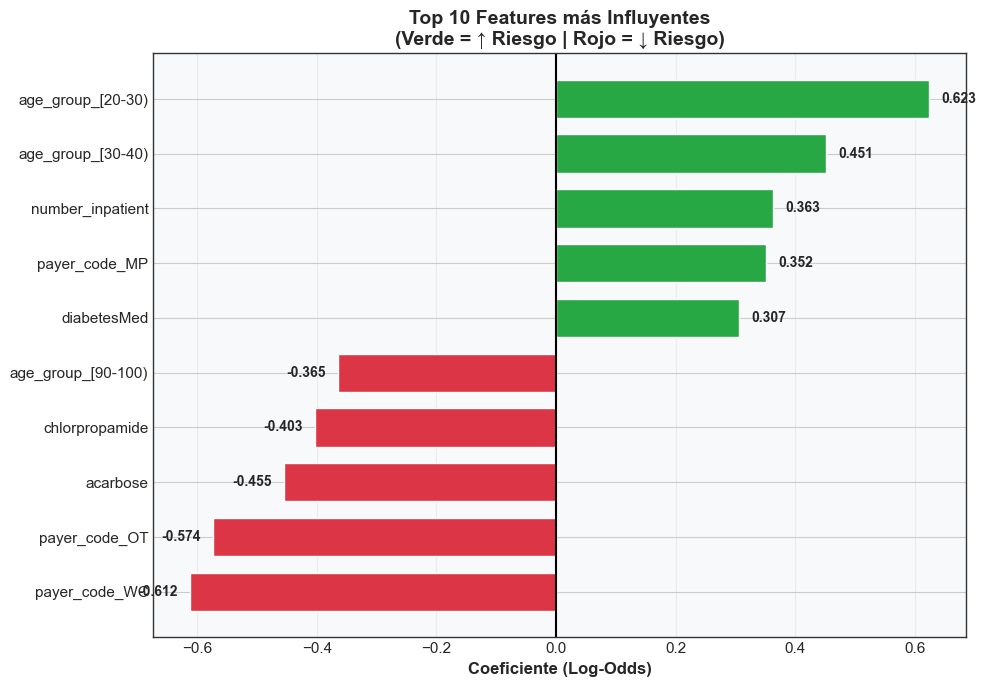

In [36]:
coefs = pd.Series(log_reg.coef_[0], index=X.columns)
top_features = coefs.abs().sort_values(ascending=False).head(10)
top_features_original = coefs[top_features.index].sort_values()

fig, ax = plt.subplots(figsize=(10, 7))
colors = [COLORS['success'] if x > 0 else COLORS['danger'] for x in top_features_original]
bars = ax.barh(range(len(top_features_original)), top_features_original.values, color=colors, edgecolor='white', height=0.7)

ax.set_yticks(range(len(top_features_original)))
ax.set_yticklabels(top_features_original.index, fontsize=11)
ax.axvline(x=0, color='black', linewidth=1.5)
ax.set_xlabel('Coeficiente (Log-Odds)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Features más Influyentes\n(Verde = ↑ Riesgo | Rojo = ↓ Riesgo)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for bar, val in zip(bars, top_features_original.values):
    width = bar.get_width()
    ax.text(width + 0.02 if width > 0 else width - 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', ha='left' if width > 0 else 'right', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**Interpretación de features:**
- **Aumentan riesgo (verde):** pacientes jóvenes (20-40 años), más visitas previas (`number_inpatient`), uso de medicación para diabetes
- **Disminuyen riesgo (rojo):** ciertos códigos de pagador, pacientes muy mayores (90-100), algunos medicamentos específicos

Sorprendentemente, los pacientes más jóvenes presentan mayor riesgo de readmisión, posiblemente relacionado con menor adherencia al tratamiento o condiciones más agudas.

## Árboles de decisión

Los **árboles de decisión** son modelos no lineales que crean reglas de decisión interpretables. A diferencia de la regresión logística, pueden capturar relaciones más complejas entre variables.

### Visualización del árbol (profundidad limitada)

Entrenamos un árbol con profundidad máxima de 3 niveles para poder visualizar e interpretar las reglas aprendidas.

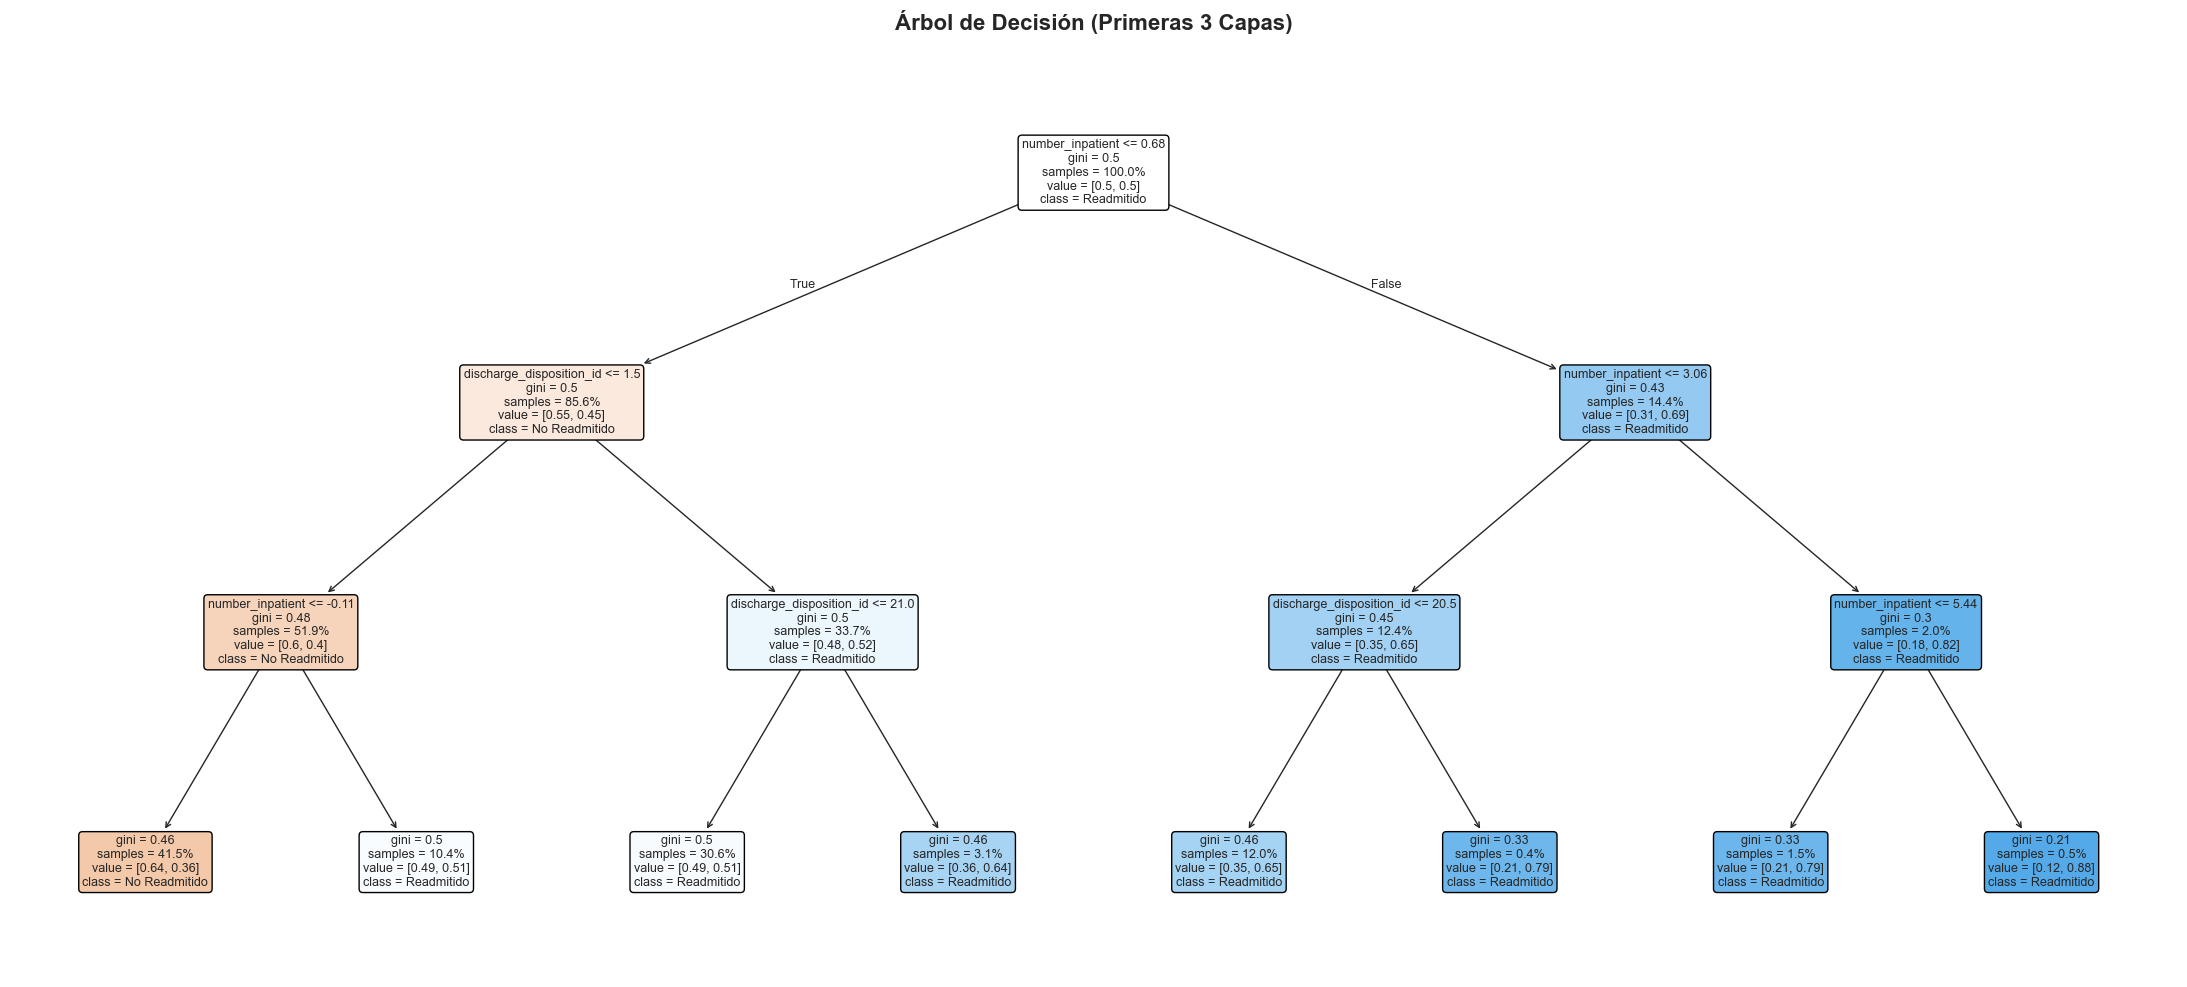

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

# Árbol para visualización
tree_viz = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)
tree_viz.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(22, 10))
plot_tree(tree_viz, feature_names=X.columns, class_names=['No Readmitido', 'Readmitido'], 
          filled=True, rounded=True, fontsize=9, proportion=True, ax=ax, impurity=True, precision=2)
ax.set_title('Árbol de Decisión (Primeras 3 Capas)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

**Interpretación del árbol:**
- La primera división usa `number_inpatient` (visitas previas como paciente interno): son pacientes con más visitas previas que tienen mayor probabilidad de readmisión
- Las siguientes divisiones usan `discharge_disposition_id` (tipo de alta) y otros indicadores de uso previo del sistema de salud
- Los nodos más oscuros (azul intenso) indican mayor proporción de readmitidos

### Diagnóstico de overfitting

Comparamos el rendimiento en train vs test con un árbol sin restricciones para detectar sobreajuste.

In [38]:
# Árbol completo sin poda (para comparar overfitting)
tree_full = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_full.fit(X_train, y_train)

# Comparamos rendimiento en train vs test
y_pred_train_full = tree_full.predict(X_train)
y_pred_test_full = tree_full.predict(X_test)

print("Árbol Completo (sin poda):")
print(f"  • Profundidad del árbol: {tree_full.get_depth()}")
print(f"  • Número de hojas: {tree_full.get_n_leaves()}")
print(f"  • F1-Score en Train: {f1_score(y_train, y_pred_train_full):.4f}")
print(f"  • F1-Score en Test:  {f1_score(y_test, y_pred_test_full):.4f}")
print(f"\nLa diferencia entre train y test indica {'OVERFITTING' if f1_score(y_train, y_pred_train_full) - f1_score(y_test, y_pred_test_full) > 0.1 else 'buen ajuste'}")

Árbol Completo (sin poda):
  • Profundidad del árbol: 54
  • Número de hojas: 13437
  • F1-Score en Train: 1.0000
  • F1-Score en Test:  0.1670

La diferencia entre train y test indica OVERFITTING


## Validación cruzada y optimización

Para asegurar que nuestros resultados son robustos y no dependen de una única división train/test, utilizamos **validación cruzada**. Además, buscamos los mejores hiperparámetros para el Árbol de Decisión mediante **GridSearchCV**.

### Validación cruzada (10-Fold) para la Regresión Logística

Evaluamos el modelo en 10 particiones diferentes para obtener una estimación más confiable de su rendimiento.

In [39]:
from sklearn.model_selection import cross_val_score, GridSearchCV
import time

cv_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results_log = {}

for metric in cv_metrics:
    scores = cross_val_score(log_reg, X_train, y_train, cv=10, scoring=metric)
    cv_results_log[metric] = {'mean': scores.mean(), 'std': scores.std()}
    print(f"{metric.capitalize():<12}: {scores.mean():.4f} ± {scores.std():.4f}")

Accuracy    : 0.6615 ± 0.0074
Precision   : 0.1682 ± 0.0055
Recall      : 0.5152 ± 0.0176
F1          : 0.2536 ± 0.0080
Roc_auc     : 0.6406 ± 0.0090


Los resultados muestran consistencia entre los 10 folds (desviaciones estándar bajas). El Recall de ~0.53 indica que detectamos aproximadamente la mitad de los pacientes readmitidos.

### GridSearch para Árbol de Decisión

Buscamos la combinación óptima de hiperparámetros probando 40 combinaciones diferentes con validación cruzada de 5 folds, optimizando para F1-Score.

In [40]:
param_grid = {
    'max_depth': [5, 8, 10, 12, 15],
    'min_samples_leaf': [10, 20, 50, 100],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42), 
    param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=0
)
grid_search.fit(X_train, y_train)
best_tree = grid_search.best_estimator_

print(f"Mejores parámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  • {param}: {value}")
print(f"\nMejor F1-Score (CV): {grid_search.best_score_:.4f}")

Mejores parámetros encontrados:
  • criterion: entropy
  • max_depth: 5
  • min_samples_leaf: 50

Mejor F1-Score (CV): 0.2642


El GridSearch encuentra que los mejores parámetros son `max_depth=5`, `min_samples_leaf=50` y `criterion=entropy`. Esto confirma que un árbol más podado (menos profundo) generaliza mejor que uno sin restricciones.

### Comparativa Final de Modelos

Evaluamos todos los modelos entrenados en el conjunto de test para obtener una comparación justa.

In [41]:
models = {
    'Regresión logística': log_reg,
    'Árbol simple (depth=3)': tree_viz,
    'Árbol completo (sin poda)': tree_full,
    'Árbol optimizado (GridSearch)': best_tree
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    report = classification_report(y_test, y_pred, output_dict=True)
    fpr_temp, tpr_temp, _ = roc_curve(y_test, y_prob)
    roc_auc_temp = auc(fpr_temp, tpr_temp)
    
    results.append({
        'Modelo': name,
        'Accuracy': report['accuracy'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'AUC-ROC': roc_auc_temp
    })

df_results = pd.DataFrame(results).set_index('Modelo')
df_results.round(4)

,Accuracy,Precision,Recall,F1-Score,AUC-ROC
Modelo,,,,,
Regresión logística,0.6624,0.1714,0.5284,0.2589,0.6443
Árbol simple (depth=3),0.4709,0.1450,0.7640,0.2437,0.6352
Árbol completo (sin poda),0.8078,0.1616,0.1726,0.1670,0.5301
Árbol optimizado (GridSearch),0.6387,0.1730,0.5923,0.2678,0.6582


**Análisis de resultados:**
- El **Árbol Optimizado** obtiene el mejor F1-Score (~0.27) y AUC-ROC (~0.66)
- La **Regresión Logística** tiene un rendimiento muy similar, siendo más interpretable
- El **Árbol Simple (depth=3)** maximiza el Recall (~0.76) pero con baja Precision
- El **Árbol Completo** sufre overfitting severo, con el peor rendimiento general

### Visualización Comparativa

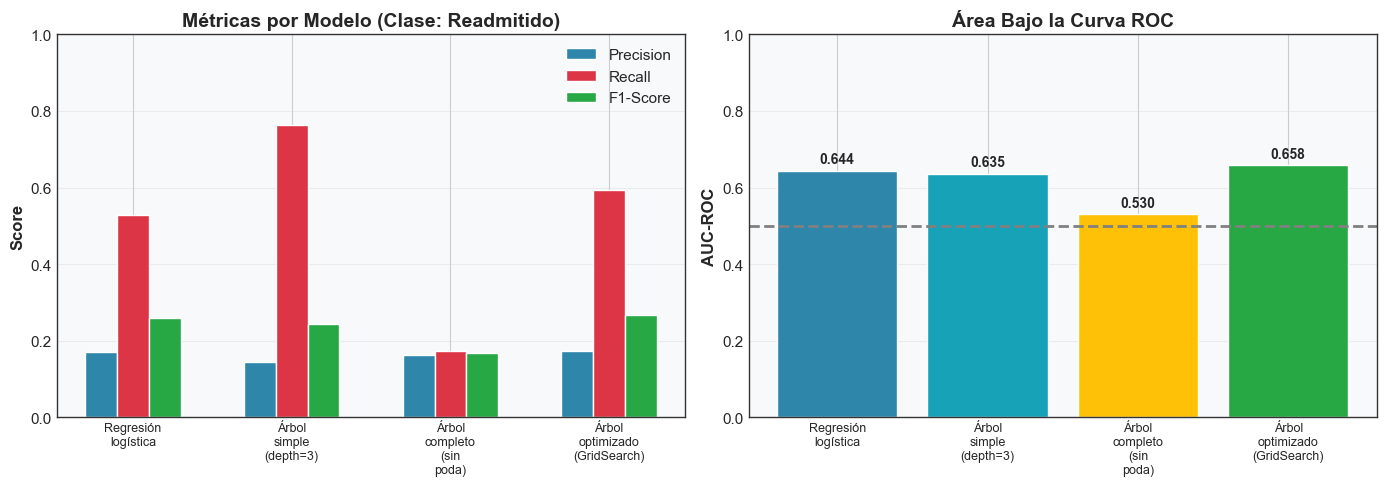

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_names = df_results.index.tolist()
x_pos = np.arange(len(models_names))
width = 0.2

# Gráfica 1: Precision, Recall, F1
ax1 = axes[0]
ax1.bar(x_pos - width, df_results['Precision'], width, label='Precision', color=COLORS['primary'], edgecolor='white')
ax1.bar(x_pos, df_results['Recall'], width, label='Recall', color=COLORS['danger'], edgecolor='white')
ax1.bar(x_pos + width, df_results['F1-Score'], width, label='F1-Score', color=COLORS['success'], edgecolor='white')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Métricas por Modelo (Clase: Readmitido)', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([m.replace(' ', '\n') for m in models_names], fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# Gráfica 2: AUC-ROC
ax2 = axes[1]
bars = ax2.bar(x_pos, df_results['AUC-ROC'], color=[COLORS['primary'], COLORS['info'], COLORS['warning'], COLORS['success']], edgecolor='white')
ax2.axhline(y=0.5, color='gray', linestyle='--', linewidth=2, label='Aleatorio')
ax2.set_ylabel('AUC-ROC', fontsize=12, fontweight='bold')
ax2.set_title('Área Bajo la Curva ROC', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([m.replace(' ', '\n') for m in models_names], fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1)
for bar in bars:
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, f'{bar.get_height():.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Curvas ROC Comparativas

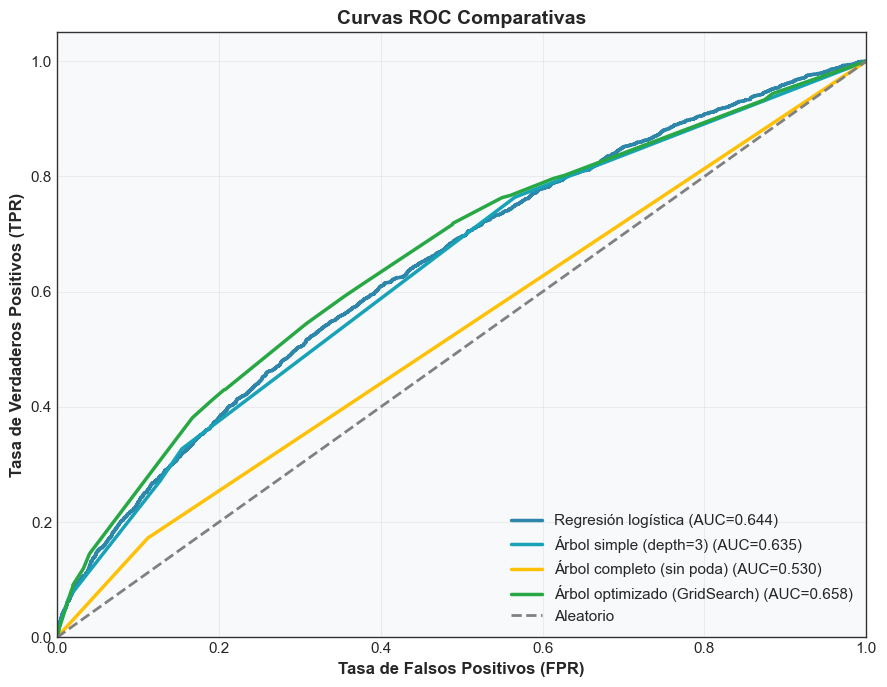

In [43]:
fig, ax = plt.subplots(figsize=(9, 7))
colors_list = [COLORS['primary'], COLORS['info'], COLORS['warning'], COLORS['success']]

for (name, model), color in zip(models.items(), colors_list):
    y_prob_temp = model.predict_proba(X_test)[:, 1]
    fpr_temp, tpr_temp, _ = roc_curve(y_test, y_prob_temp)
    roc_auc_temp = auc(fpr_temp, tpr_temp)
    ax.plot(fpr_temp, tpr_temp, color=color, lw=2.5, label=f'{name} (AUC={roc_auc_temp:.3f})')

ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Aleatorio')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12, fontweight='bold')
ax.set_title('Curvas ROC Comparativas', fontsize=14, fontweight='bold')
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Las curvas ROC confirman que el **Árbol Optimizado** y la **Regresión Logística** tienen el mejor poder discriminativo, mientras que el **Árbol Completo** (sin poda) tiene el peor rendimiento debido al overfitting.

### Recomendación Final

En contexto médico, el **recall** es crítico: preferimos detectar más pacientes en riesgo (aunque tengamos falsos positivos) que dejar pasar pacientes que serán readmitidos. Sin embargo, si los recursos del hospital son limitados, el **f1-Score** ofrece un mejor equilibrio.

El **árbol optimizado** o la **Regresión Logística** son las mejores opciones, dependiendo de si priorizamos interpretabilidad (árboles) o simplicidad (regresión).

---

## 📚 Referencias

1. Abdul-Aziz AA, Hayward RA, Aaronson KD, Hummel SL. Association Between Medicare Hospital Readmission Penalties and 30-Day Combined Excess Readmission and Mortality. JAMA Cardiol. 2017;2(2):200–203. doi:10.1001/jamacardio.2016.3704
2. Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). Diabetes 130-US Hospitals for Years 1999-2008 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.
3. Dunbar P, Hall M, Gay JC, Hoover C, Markham JL, Bettenhausen JL, Perrin JM, Kuhlthau KA, Crossman M, Garrity B, Berry JG. Hospital Readmission of Adolescents and Young Adults With Complex Chronic Disease. JAMA Netw Open. 2019 Jul 3;2(7):e197613. doi: 10.1001/jamanetworkopen.2019.7613. PMID: 31339547; PMCID: PMC6659144.
4. Freire, A. X., Umpierrez, G. E., Afessa, B., Latif, K. A., Bridges, L., & Kitabchi, A. E. (2002). Predictors of intensive care unit and hospital length of stay in diabetic ketoacidosis. Journal of Critical Care, 17(4), 207–211. https://doi.org/10.1053/jcrc.2002.36755
5. Jade Gek Sang Soh, Amartya Mukhopadhyay, Bhuvaneshwari Mohankumar, Swee Chye Quek, Bee Choo Tai, Predicting and Validating 30-day Hospital Readmission in Adults With Diabetes Whose Index Admission Is Diabetes-related, The Journal of Clinical Endocrinology & Metabolism, Volume 107, Issue 10, October 2022, Pages 2865–2873, https://doi.org/10.1210/clinem/dgac380
6. Ministry of Health. (2017, 11 abril). Diagnostic Code Descriptions (ICD-9) - Province of British Columbia. https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9
7. Scikit-learn Documentation - https://scikit-learn.org/
8. Strack, B., DeShazo, J. P., Gennings, C., et al. (2014). Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records. *BioMed Research International*.


---